In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

import itertools
import pickle
import json

from sklearn.preprocessing import PowerTransformer, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.selection import DropDuplicateFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
from optbinning import BinningProcess, OptimalBinning

from sklearn.feature_selection import SelectFromModel, SelectKBest

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, log_loss, roc_curve

import optuna

import warnings
warnings.simplefilter('ignore')    # ignore warnings

(CVXPY) Nov 16 07:52:27 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 16 07:52:27 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


/home/mai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## 1. Load data

For our analysis, we will use the training dataset located at `./data/train.csv`

This Dataset is the training dataset in a Hackathon organized by Deloitte. The aim is to predict whether a person will be a loan defaulter or not by looking at various attributes like funded amount, location, loan, balance, etc. In reality, banks and finance institutions would create credit scorecards for such tasks and rank their customers by credit score.

In first sections of this notebook, we will focus on feature engineering to extract and prepare our dataset for a classifier algorithm. At the end, we will use the engineered features to fit a classifier.

In [3]:
df = pd.read_csv('./data/train.csv')

df.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


Brief description of columns:

- `ID`: unique ID of representative
- `Loan Amount`: loan amount applied
- `Funded Amount`: loan amount funded
- `Funded Amount Investor`: loan amount approved by the investors
- `Term`: term of loan (in months)
- `Batch Enrolled`: batch numbers to representatives
- `Interest Rate`: interest rate (%) on loan
- `Grade`: grade by the bank
- `Sub Grade`: sub-grade by the bank
- `Employment Duration`: duration
- `Home Ownership`: Ownership of home
- `Verification Status`: Income verification by the bank
- `Payment Plan`: if any payment plan has started against loan
- `Loan Title`: loan title provided
- `Debit to Income`: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
- `Delinquency - two years`: number of 30+ days delinquency in past 2 years
- `Inquiries - six months`: total number of inquiries in last 6 months
- `Open Account`: number of open credit line in representative's credit line
- `Public Records`: number of derogatory public records
- `Revolving Balance`: total credit revolving balance
- `Revolving Utilities`: amount of credit a representative is using relative to Revolving Balance
- `Total Accounts`: total number of credit lines available in representative's credit lines
- `Initial List Status`: unique listing status of the loan - W(Waiting), F(Forwarded)
- `Total Received Interest`: total interest received till date
- `Total Received Late Fee`: total late fee received till date
- `Recoveries`: post charge off gross recovery
- `Collection Recovery Fee`: post charge off collection fee
- `Collection 12 months Medical`: total collections in last 12 months excluding medical collections
- `Application Type`: indicates when the representative is an individual or joint
- `Last week Pay`: indicates how long (in weeks) a representative has paid EMI after batch enrolled
- `Accounts Delinquent`: number of accounts on which the representative is delinquent
- `Total Collection Amount`: total collection amount ever owed
- `Total Current Balance`: total current balance from all accounts
- `Total Revolving Credit Limit`: total revolving credit limit
- `Loan Status`: 1 = Defaulter, 0 = Non-defaulter

First, it seems like the data in `Employment Duration` should have been `Home Ownership`. We are not sure what the data in `Home Ownership` would have been, but one possibility is income. So for now, let's just swap the two column labels.

In [4]:
df[['Home Ownership', 'Employment Duration']] = df[['Employment Duration', 'Home Ownership']]

In [5]:
# let's also convert the column names to lowercase snake case 
col_names_new = [var.lower().replace('- ', '').replace(' ', '_') for var in df.columns]
df.columns = col_names_new

df.head(10)

,id,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,employment_duration,home_ownership,verification_status,payment_plan,loan_title,debit_to_income,delinquency_two_years,inquires_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,accounts_delinquent,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_status
0,65087372,10000,32236,12329.362860,59,BAT2522922,11.135007,B,C4,176346.62670,MORTGAGE,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.996920,59,BAT1586599,12.237563,C,D3,39833.92100,RENT,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.224550,59,BAT2136391,12.545884,F,D4,91506.69105,MORTGAGE,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.155850,59,BAT2428731,16.731201,C,C3,108286.57590,MORTGAGE,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.926670,59,BAT5341619,15.008300,C,D4,44234.82545,MORTGAGE,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0
5,50509046,34631,30203,8635.931613,36,BAT4694572,17.246986,B,G5,98957.47561,RENT,Not Verified,n,Credit card refinancing,7.914333,3,2,16,0,2277,51.564476,20,w,464.818124,0.088584,5.043575,0.581688,0,INDIVIDUAL,32,0,42,51252,27480,0
6,32737431,30844,19773,15777.511830,59,BAT4808022,10.731432,C,C5,102391.82430,RENT,Verified,n,Home improvement,15.083911,0,0,11,0,14501,46.808804,37,w,525.738109,0.083528,3.167937,0.553076,0,INDIVIDUAL,71,0,3388,42069,31068,0
7,63151650,20744,10609,7645.014802,58,BAT2558388,13.993688,A,A5,61723.52014,OWN,Not Verified,n,Debt consolidation,29.829715,0,0,14,0,13067,23.936624,33,w,1350.245212,0.044965,0.098448,0.047589,0,INDIVIDUAL,87,0,48,184909,43303,0
8,4279662,9299,11238,13429.456610,59,BAT5341619,11.178457,G,C2,63205.09072,MORTGAGE,Verified,n,Credit card refinancing,26.244710,0,0,6,0,549,15.947386,17,w,4140.198978,0.017106,0.530214,0.216985,0,INDIVIDUAL,144,0,26,68126,7482,0
9,4431034,19232,8962,7004.097481,58,BAT2078974,5.520413,C,B5,42015.46586,RENT,Source Verified,n,Credit card refinancing,10.048549,1,0,11,0,1361,35.073345,30,f,2149.666963,0.008338,2.912215,0.886864,0,INDIVIDUAL,9,0,35,71650,14871,0


In [6]:
# check the number of rows and columns
df.shape

(67463, 35)

In [7]:
# Displays column names, complete (non-missing) cases per column, and datatype per column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            67463 non-null  int64  
 1   loan_amount                   67463 non-null  int64  
 2   funded_amount                 67463 non-null  int64  
 3   funded_amount_investor        67463 non-null  float64
 4   term                          67463 non-null  int64  
 5   batch_enrolled                67463 non-null  object 
 6   interest_rate                 67463 non-null  float64
 7   grade                         67463 non-null  object 
 8   sub_grade                     67463 non-null  object 
 9   employment_duration           67463 non-null  float64
 10  home_ownership                67463 non-null  object 
 11  verification_status           67463 non-null  object 
 12  payment_plan                  67463 non-null  object 
 13  l

Our data does not have any missing data.

In [8]:
# get some descriptive statistics
# for categorical features, we will also see the number of unique values
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,67463.0,NaN,NaN,NaN,25627607.746498,21091554.023733,1297933.0,6570288.0,17915646.0,42715208.5,72245779.0
loan_amount,67463.0,NaN,NaN,NaN,16848.902776,8367.865726,1014.0,10012.0,16073.0,22106.0,35000.0
funded_amount,67463.0,NaN,NaN,NaN,15770.599114,8150.992662,1014.0,9266.5,13042.0,21793.0,34999.0
funded_amount_investor,67463.0,NaN,NaN,NaN,14621.799323,6785.34517,1114.590204,9831.684984,12793.68217,17807.59412,34999.74643
term,67463.0,NaN,NaN,NaN,58.173814,3.327441,36.0,58.0,59.0,59.0,59.0
batch_enrolled,67463,41,BAT3873588,3626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interest_rate,67463.0,NaN,NaN,NaN,11.846258,3.718629,5.320006,9.297147,11.377696,14.193533,27.182348
grade,67463,7,C,19085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,67463,35,B4,4462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_duration,67463.0,NaN,NaN,NaN,80541.502522,45029.120366,14573.53717,51689.843335,69335.83268,94623.322785,406561.5364


In [9]:
# let's separate the data into target and features
target = 'loan_status'

y = df[target]
X = df[[col for col in df.columns if col not in [target, 'id']]]

In [10]:
X.shape, y.shape

((67463, 33), (67463,))

## 2. Extract more features from the existing features

Based on the features' description, we can extract some more features from the existing ones.

In [11]:
# Group 1: features related to loan amount, funded, and funded investor amount
# total funded and funded investor
X['funded_sum'] = X['funded_amount'] + X['funded_amount_investor']
# loan amount to funded amount ratio
X['loan_to_funded'] = X['loan_amount'] / X['funded_amount']
# loan amount to funded investor ratio
X['loan_to_funded_investor'] = X['loan_amount'] / X['funded_amount_investor']
# funded to funded investor ratio
X['funded_to_funded_investor'] = X['funded_amount'] / X['funded_amount_investor']

In [12]:
# Group 2: interest rate, debit to income and employment duration
# income to interest rate 
X['employment_to_interest'] = X['employment_duration'] / X['interest_rate']
# interest rate to debit to income
X['interest_to_debit'] = X['interest_rate'] / X['debit_to_income']

In [13]:
# Group 3: delinquencies, public record, open account
# any inquries in last six months
X['any_inquires_six_months'] = (X['inquires_six_months'] > 0).astype(int).astype(object)
# any delinquency last 2 years
X['any_delinquency_two_years'] = (X['delinquency_two_years'] > 0).astype(int).astype(object)
# any collections in last 12 months excluding medical collections
X['any_collection_12_months_medical'] = (X['collection_12_months_medical'] > 0).astype(int).astype(object)
# any public derogatory records
X['any_public_record'] = (X['public_record'] > 0).astype(int).astype(object)

# delinquency per open account
X['deliquencies_per_open_account'] = X['delinquency_two_years'] / X['open_account']
# inquires per open account
X['inquires_per_open_account'] = X['inquires_six_months'] / X['open_account']
# public records per open account
X['records_per_open_account'] = X['public_record'] / X['open_account']

In [14]:
# Group 4: revolving balance and utilities
# revolving balance  * revolving utilities
X['revolving_balance_utilities_prod'] = X['revolving_balance'] * X['revolving_utilities']

In [15]:
# Group 5: open account and total accounts
X['open_account_to_total_account'] = X['open_account'] / X['total_accounts']
X['open_account_total_account_diff'] = X['total_accounts'] - X['open_account']

In [16]:
# Group 6: received interest, late fee, total accounts
X['received_interest_per_account'] = X['total_received_interest'] / X['total_accounts']
X['received_late_fee_per_account'] = X['total_received_late_fee'] / X['total_accounts']

In [17]:
# Group 7: recovereies, collection fee
X['recoveries_collection_fee_total'] = X['recoveries'] + X['collection_recovery_fee']
X['recoveries_collection_fee_prod'] = X['recoveries'] * X['collection_recovery_fee']

In [18]:
# Group 8: last week pay, total amount balance, credit limit
X['collection_amount_per_weekpay'] = X['total_collection_amount'] / X['last_week_pay']
X['current_balance_revolving_credit_limit_total'] = X['total_current_balance'] + X['total_revolving_credit_limit']
X['current_balance_to_revolving_credit_limit'] = X['total_current_balance'] / X['total_revolving_credit_limit']

In [19]:
# Modify some features
# batch number (extract the number part only)
X['batch_enrolled'] = X['batch_enrolled'].apply(lambda x: x[3:]).astype(object)
# term - treat as categorical feature
X['term'] = X['term'].astype(str).astype(object)
# subgrade - extract the numbers only
# X['sub_grade'] = X['sub_grade'].apply(lambda x: x[1]).astype(object)
# convert some numerical variables to categorical variables
X['public_record'] = X['public_record'].astype(object)
X['delinquency_two_years'] = X['delinquency_two_years'].astype(object)
X['inquires_six_months'] = X['inquires_six_months'].astype(object)

In [20]:
X.shape, y.shape

((67463, 56), (67463,))

Now, let's split our data into a train and test set. We will use the train set for the next steps of feature engineering and we will use the result pipeline to transform the test set accordingly.

In [21]:
# first, let's separate our data into a train and test set (just a subset of the data that we are leaving out for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60716, 56) (60716,)
(6747, 56) (6747,)


In [22]:
# check the number of each classes in the train and test set
print('Train set')
print(y_train.value_counts())

print('Test set')
print(y_test.value_counts())

Train set
loan_status
0    55071
1     5645
Name: count, dtype: int64
Test set
loan_status
0    6151
1     596
Name: count, dtype: int64


## 3. Drop constant, quasi-constant, and duplicate variables

Next, let's identify constant and quasi-constant variables in our dataset using a variance threshold. Variables that have lower variance than this threshold will be considered a (quasi)constant variable and will be dropped from the analysis as they will not add any useful information towards whether a person is a defaulter.

We can use `sklearn.feature_selection.VarianceThreshold` to drop features with variance below a certain threshold, but the method is only applicable to numeric variables. If we want to apply the variance threshold method on non-numeric variables, we have to code it ourselves.

In [23]:
class DropQuasiConstantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, predominant_threshold=0.998):
        self.predominant_threshold = predominant_threshold
        # create an empty list to store quasi-constant features
        self.quasi_constant_features = []
        
    def fit(self, X, y=None):
        for feature in X.columns:
            # find the predominant value (shared by most observations):
            predominant = X[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
            # evaluate the predominant value frequency: does it exceed the threshold?
            if predominant > self.predominant_threshold:
                # if yes, add the feature to the list
                self.quasi_constant_features.append(feature)

        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.drop(self.quasi_constant_features, axis=1, inplace=True)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [24]:
drop_quasi_constant = DropQuasiConstantFeatures()
# we use the fit method to get the list of quasi-constant variables
quasi_constant_vars = drop_quasi_constant.fit(X_train).quasi_constant_features

print('Quasi-constant variables:', quasi_constant_vars)

Quasi-constant variables: ['payment_plan', 'application_type', 'accounts_delinquent']


In [25]:
# let's drop these variables
X_train = drop_quasi_constant.transform(X_train)
X_test = drop_quasi_constant.transform(X_test)
# check the number of variables after dropping quasi-constant variables
print(X_train.shape, X_test.shape)

(60716, 53) (6747, 53)


Let's also check if our dataset contains any duplicated variables, that is, features with different names but are identical in values. Since there is not built-in method for detecting and removing duplicated variables in pandas or sklearn, we'll use a different open-source package `feature_engine` to accomplish this.

In [26]:
# set up a selector using feature_engine.selection.DropDuplicateFeatures
drop_duplicate = DropDuplicateFeatures(variables=None, missing_values='raise')

# find the duplicate features
drop_duplicate.fit(X_train)

# let's check if there are any pairs of duplicated features
drop_duplicate.duplicated_feature_sets_

[{'any_collection_12_months_medical', 'collection_12_months_medical'}]

Looks like the binary variable we engineered from `collection_12_months_medical` is duplicated with the original variable itself because there are only 2 distinct values in this variable (0 or 1). So let's drop one of them.

In [27]:
# check which features will be dropped
drop_duplicate.features_to_drop_

{'any_collection_12_months_medical'}

In [28]:
X_train = drop_duplicate.transform(X_train)
X_test = drop_duplicate.transform(X_test)

# check the number of variables after dropping duplicate variables
print(X_train.shape, X_test.shape)

(60716, 52) (6747, 52)


We can split our remaining variables into discrete / categorical variables and continuous variables.

In [29]:
discrete_vars = [var for var in X_train.columns if X_train[var].dtype=='object']
continuous_vars = [var for var in X_train.columns if var not in discrete_vars]

# let's check out the number of categorical variables and numerical variables
print('Number of discrete variables:', len(discrete_vars))
print('Number of continuous variables:', len(continuous_vars))

Number of discrete variables: 14
Number of continuous variables: 38


## 4. Target variable - Loan Status

Let's inspect the target variable - `Loan Status`. This is a binary variable, with `0` = Non-defaulter and `1` = Defaulter.


In [30]:
# the overall default rate
default_perc = y_train.sum() / y_train.shape[0]

print(f'The overall default rate is: {default_perc:.4f}')

The overall default rate is: 0.0930


Our dataset is highly imbalanced. The ratio of Non-defaulters to Defaulters is roughly 10:1

## 5. Discrete variables

### 5.1. Quick inspection

Let's check out the list of categorical variables and how many unique categories each of them contains.

In [31]:
X_train[discrete_vars].nunique().sort_values()

initial_list_status            2
any_inquires_six_months        2
any_delinquency_two_years      2
any_public_record              2
term                           3
home_ownership                 3
verification_status            3
public_record                  5
inquires_six_months            6
grade                          7
delinquency_two_years          9
sub_grade                     35
batch_enrolled                41
loan_title                   109
dtype: int64

We notice that these variables can be divided into 3 groups:  binary variables, ordinal variables, and nominal variables

In [32]:
# let's define our groups of variables here
binary_variables = [var for var in discrete_vars if X_train[var].nunique() == 2]
ordinal_variables = ['grade', 'sub_grade', 'public_record', 'delinquency_two_years', 'inquires_six_months']
nominal_variables = [var for var in discrete_vars if var not in binary_variables and var not in ordinal_variables]

### 5.2. Some data cleaning

Some variables are high-cardinality - `loan_title`. In particular, the inconsistent values in `Loan Title` are likely the result of manual data entry. To properly analyze the data in this variable, we need to clean it.

In [33]:
class LoanTitleCleanUp(BaseEstimator, TransformerMixin):
    def __init__(self, feature='loan_title', rare_threshold=0.01):
        self.feature = feature
        self.rare_threshold = rare_threshold
        
    def fit(self, X, y=None):
        self.mapping = {
            'consolidation loan': 'debt consolidation',
            'debt consolidation loan': 'debt consolidation',
            'consolidation': 'debt consolidation',
            'loan': 'other',
            'credit card debt': 'credit card',
            'credit card loan': 'credit card',
            'debt loan': 'other',
            'credit cards': 'credit card',
            'cards': 'credit card',
            'credit consolidation': 'credit card consolidation',
            'credit card refi': 'credit card refinancing',
            'credit card refinance': 'credit card refinancing',
            'debt free': 'debt payoff',
            'bathroom': 'home improvement',
            'dept consolidation': 'debt consolidation',
            'credit cardrefinance': 'credit card refinancing',
            'get out of debt': 'debt payoff',
            'credit loan': 'credit card',
            'car loan': 'major purchase',
            'car financing': 'major purchase',
            'loan consolidation': 'debt consolidation',
            'credit card refinance loan': 'credit card refinancing',
            'credit': 'credit card'
        }
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        # first, let's convert the values to lower case, remove leading spaces, and remove any special characters
        X_transformed[self.feature] = X[self.feature].str.lower().str.lstrip().str.replace(r'[^a-z\s]', '', regex=True).str.strip()
        # replace synonyms
        X_transformed[self.feature] = X_transformed[self.feature].str.replace('cc', 'credit card')\
                                    .str.replace('cc', 'credit card')\
                                    .str.replace('consolidate', 'consolidation')\
                                    .apply(lambda x: 'medical expenses' if 'medical' in x else x)\
                                    .apply(lambda x: 'home improvement' if 'home' in x else x)\
                                    .apply(lambda x: 'bill payments' if 'bill' in x else x)

        # apply the mapping
        X_transformed[self.feature] = X_transformed[self.feature].replace(self.mapping)

        # Handle rare categories
        frequencies = X_transformed[self.feature].value_counts(normalize=True)
        X_transformed[self.feature] = X_transformed[self.feature].apply(lambda x: 'other' if frequencies[x] < self.rare_threshold else x)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [34]:
# test the transformer - we want to set up a pipeline that can be reused later so for now, we will not overwrite X with our fit & transform method
loan_title_clean = LoanTitleCleanUp('loan_title', 0.0015)

In [35]:
# we can test to see if this transformation works and see how the categories of loan title is updated
X_train = loan_title_clean.fit_transform(X_train, y_train)
X_test = loan_title_clean.transform(X_test)

In [36]:
X_train['loan_title'].value_counts(normalize=True).sort_values(ascending=False)

loan_title
credit card refinancing      0.457425
debt consolidation           0.430167
other                        0.050761
home improvement             0.035938
major purchase               0.009322
medical expenses             0.003854
credit card                  0.003360
business                     0.002833
credit card consolidation    0.002273
moving and relocation        0.002223
vacation                     0.001845
Name: proportion, dtype: float64

### 5.3. Variable Encoding

Let's see how the default rate is distributed across different labels in the categorical variables.

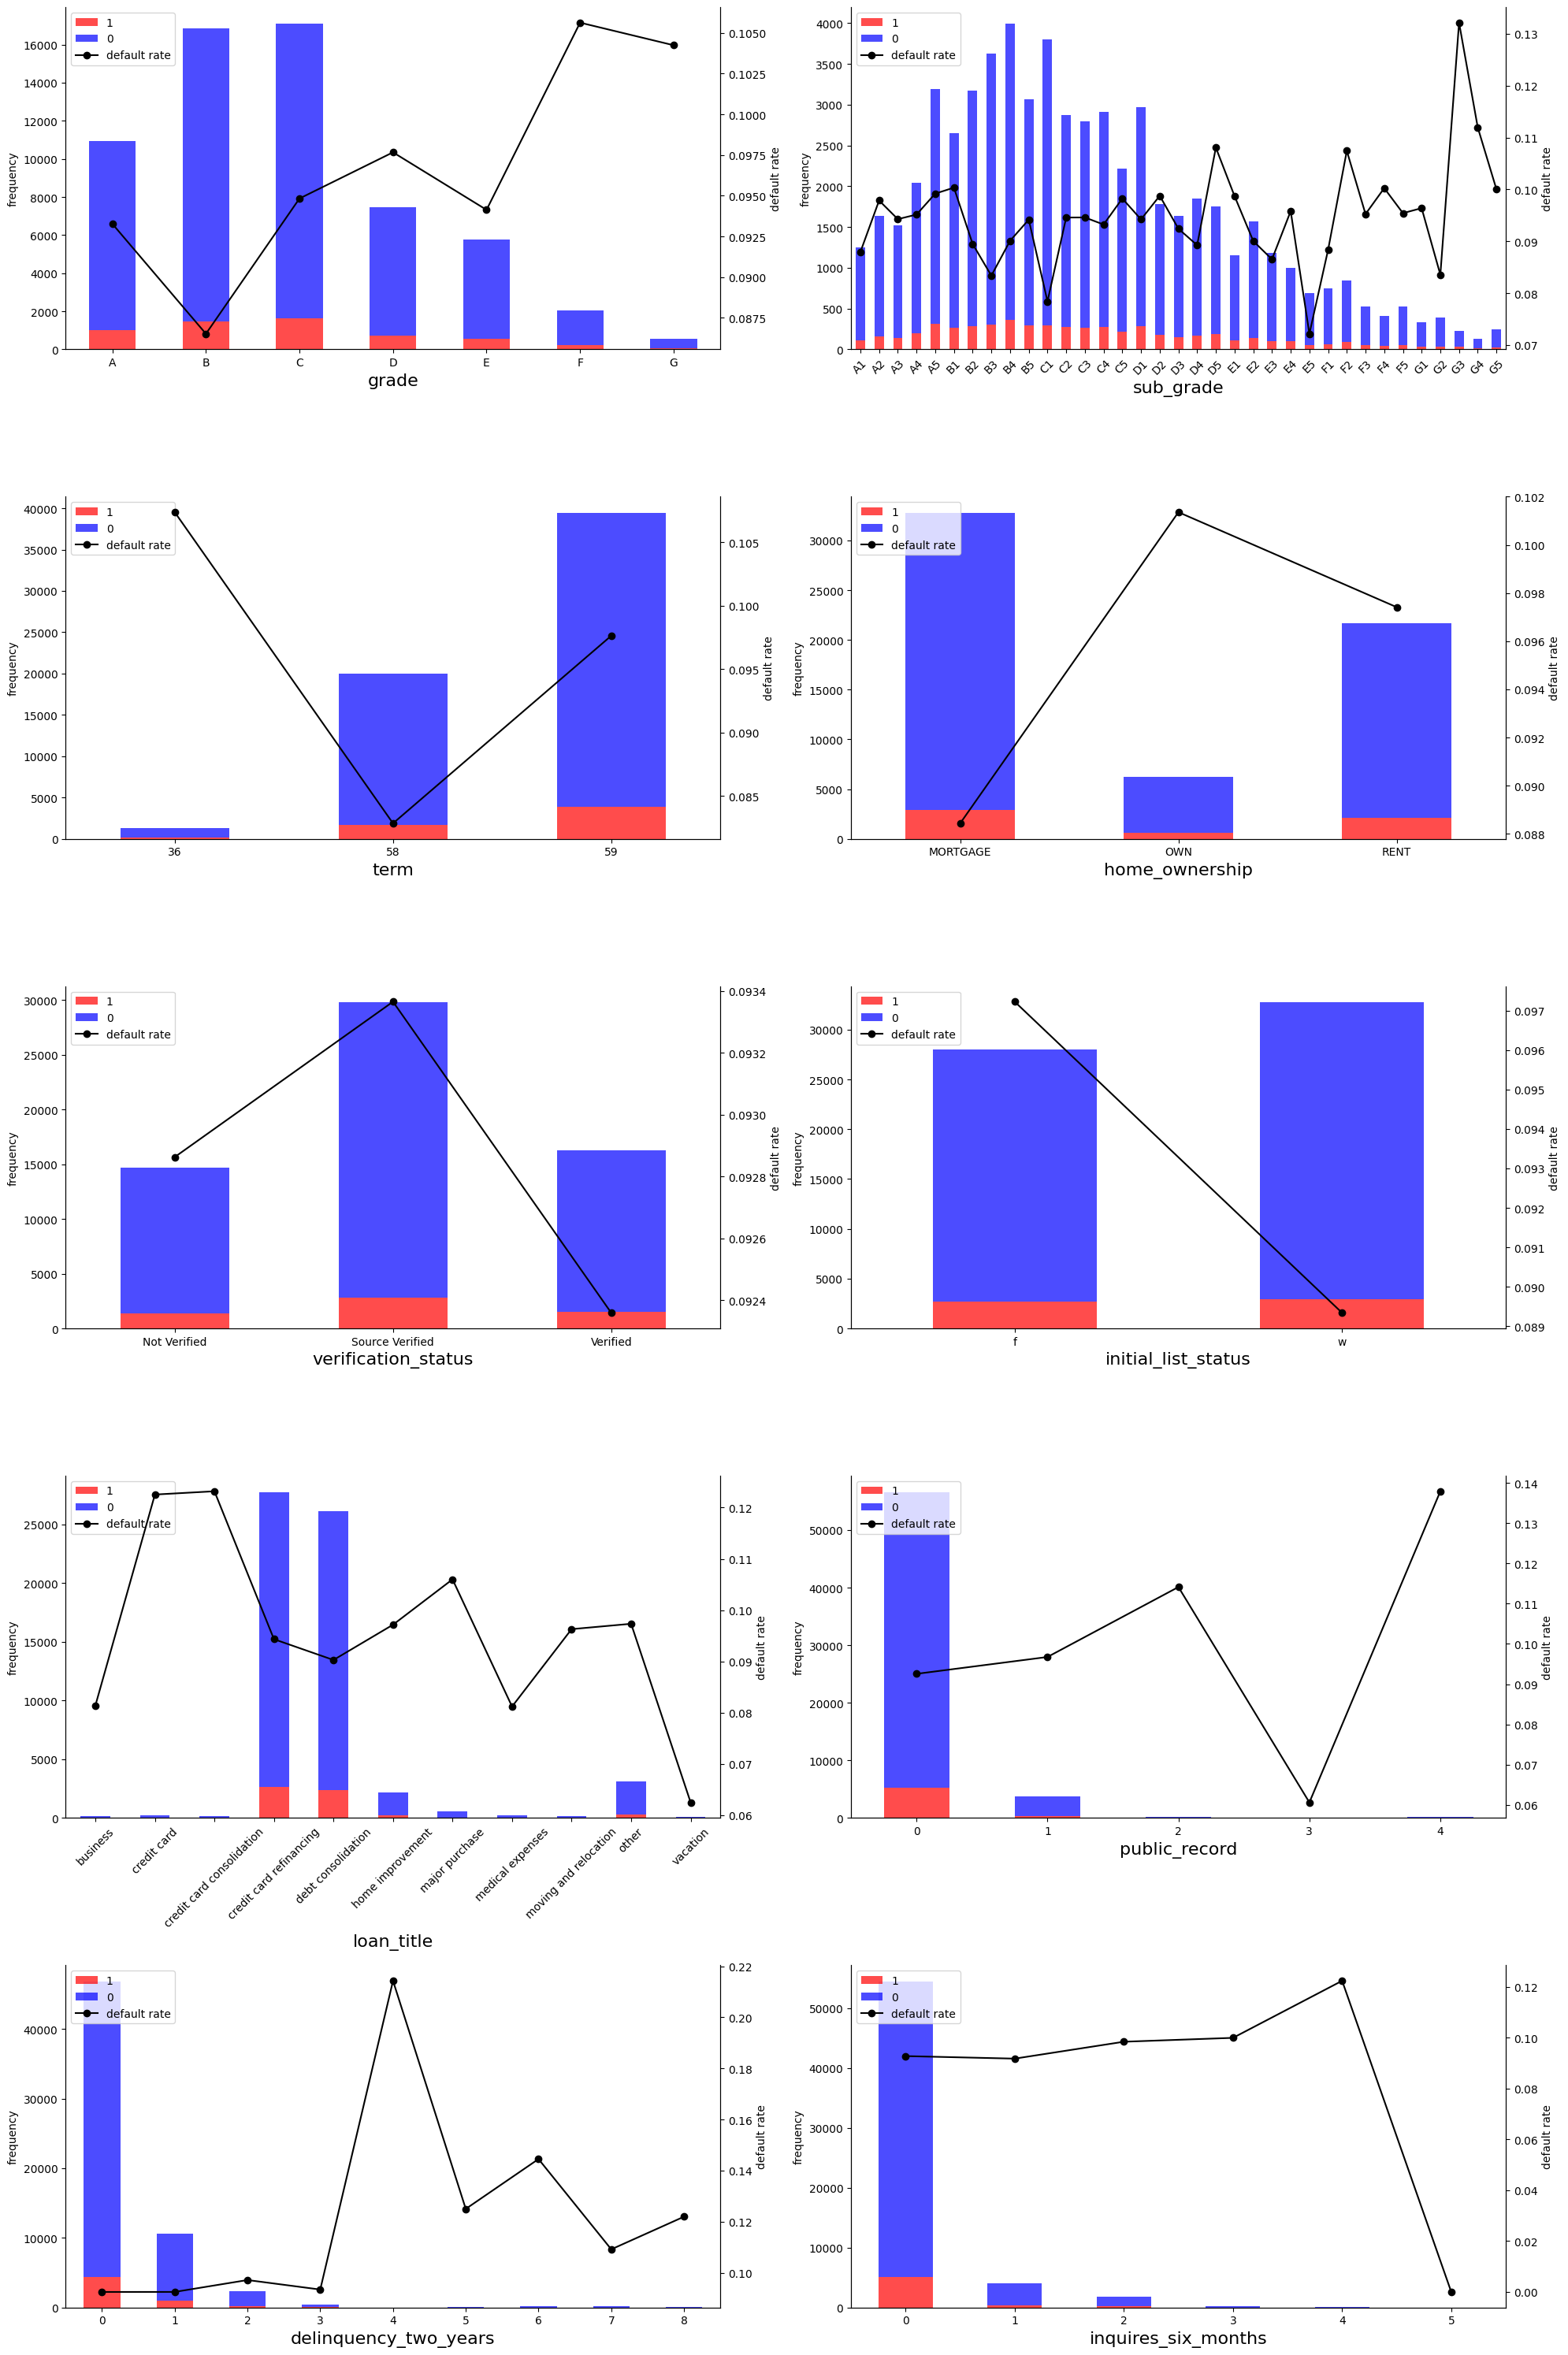

In [37]:
vars_to_plot = ['grade', 'sub_grade', 'term', 'home_ownership', 
                'verification_status', 'initial_list_status', 
                'loan_title', 'public_record', 
                'delinquency_two_years', 'inquires_six_months']

fig, ax = plt.subplots(5, 2, figsize=(20, 30))
ax = ax.ravel()
# fig.delaxes(ax[-1])

for i, var in enumerate(vars_to_plot):
    tmp = pd.concat([X_train[var], y_train], axis=1)
    tmp.groupby([var, target]).size().unstack(fill_value=0)[[1, 0]].plot(kind='bar', 
                                                                         stacked=True, 
                                                                         ax=ax[i], 
                                                                         color=['red', 'blue'], 
                                                                         alpha=0.7,
                                                                         label='label frequency')
    # X_train[var].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[i], label='label frequency')
    if X_train[var].nunique() > 10:
        ax[i].tick_params(axis='x', rotation=45)
    else:
        ax[i].tick_params(axis='x', rotation=0)
    ax[i].set_ylabel('frequency')
    ax[i].set_xlabel(var, fontsize=16)
    
    ax2 = ax[i].twinx()
    
    tmp.groupby(var)['loan_status'].mean().plot(ax=ax2, color='black', marker='o', label='default rate')
    ax2.set_ylabel('default rate')

    ax[i].spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # Combine legends for frequency and default rate into one legend box
    handles1, labels1 = ax[i].get_legend_handles_labels()   # Handles and labels for the frequency
    handles2, labels2 = ax2.get_legend_handles_labels()     # Handles and labels for the default rate
    ax[i].legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # Combined legend

# fig.set_title('Label frequency vs. Default rate')
plt.tight_layout()
plt.show()

One encoding method typically used in credit scoring is **Weight of Evidence**, which quantifies the relationship between a category of a variable and a binary target. In other words, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). In doing so, it also creates a monotonic relationships between the encoded variable and the target, which works better with our linear models.

The formula for calculting WoE for a category within a variable is as follows:

$$WOE = ln(\frac {\text{Distribution of events}} {\text{Distribution of non-events}})$$

WoE is especially well suited for linear models like Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

Let's create a custom transformer that will apply WoE encoding to our variables.

In [38]:
class WoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.woe_dict = {}
        
    def fit(self, X, y):
        X_ = X.copy()
        X_['target'] = y
        for var in X.columns:
            # calculate event and non-event prob
            event_prob = X_.groupby(var)['target'].mean()
            non_event_prob = 1 - event_prob
            # calculate woe, handling division by 0 with np.log(1e-6)
            self.woe_dict[var] = np.log((event_prob + 1e-6) / (non_event_prob + 1e-6)).to_dict()

        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X_transformed[var].map(self.woe_dict[var]).fillna(0)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self    

In addition, we can also use **Frequency Encoding**, which involves replacing the category labels with the category's frequency. This encoding method is used quite often in hackathons and Kaggle competitions. So we can also try that with this dataset.

Let's also create our custom transformer that will apply Frequency Encoding.

In [39]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.frequency_dict = {}
    def fit(self, X, y=None):
        for var in X.columns:
            # calculate category frequency
            freq_ = X[var].value_counts(normalize=True).to_dict()
            self.frequency_dict[var] = freq_
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X[var].map(self.frequency_dict[var]).fillna(0)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self    

#### 5.2.1. Binary variables

Let's create a Frequency Encoder for our binary variables using the transformer we just created. To apply it on our list of binary variables, we can wrap it in an instance of ColumnTransformer. The other variables will be passed through without modification.

In [40]:
binary_enc = ColumnTransformer(
    transformers=[
        ('binary_enc', FrequencyEncoder(), binary_variables)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [41]:
# transform the binary variables
X_train = binary_enc.fit_transform(X_train, y_train)
X_test = binary_enc.transform(X_test)

In [42]:
X_train[binary_variables].head()

,initial_list_status,any_inquires_six_months,any_delinquency_two_years,any_public_record
26334,0.539051,0.896996,0.770901,0.932242
56981,0.539051,0.896996,0.770901,0.932242
53705,0.539051,0.896996,0.770901,0.932242
35406,0.539051,0.896996,0.770901,0.932242
66368,0.539051,0.896996,0.770901,0.932242


#### 5.2.2. Ordinal Variables
Next, let's tackle the ordinal variables. For these variables, let's start by replacing the string labels with integer representation that captures the order of the values.

In [43]:
class OrdinalLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X, y=None):
        for var in X.columns:
            mapping = {k:i for i,k in enumerate(sorted(X[var].unique()), 0)}
            self.mappings[var] = mapping
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            mapping = self.mappings[var]
            X_transformed[var] = X[var].map(mapping)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [44]:
# create Custom Ordinal Encoder for ordinal variables, we'll also wrap it inside a column transformer
ordinal_label_enc = ColumnTransformer(
    transformers=[
        ('ordinal_label_enc', OrdinalLabelEncoder(), ordinal_variables)     # we only need to apply this to grade since other variables are already of type integer
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [45]:
# fit and transform the ordinal variables
X_train = ordinal_label_enc.fit_transform(X_train, y_train)
X_test = ordinal_label_enc.transform(X_test)

In [46]:
X_train[ordinal_variables].head()

,grade,sub_grade,public_record,delinquency_two_years,inquires_six_months
26334,1,3,0,0,0
56981,1,13,0,0,0
53705,1,14,0,0,0
35406,0,13,0,0,0
66368,1,14,0,0,0


Before we can apply Weight of Evidence transformation on these variables, we'll further group them up to: 1) handle rare categories and 2) ensure that the event rate for each group follows a monotonic trend. To do that, we will use the `OptimalBinning` transformer from an external library called `optbinning`. 

`OptimalBinning` also provides options to transform the binned variables using Weight of Evidence, event rate, or information value. So we'll make use of this functionality when we create our custom transformer below.

In [47]:
class OptBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, dtype='categorical', solver='cp', monotonic_trend='auto', 
                 user_splits=None, user_splits_fixed=None, transform_metric='woe', cat_cutoff=None):
        self.features = features
        self.dtype = dtype
        self.solver = solver
        self.monotonic_trend = monotonic_trend
        self.user_splits = user_splits or {}
        self.user_splits_fixed = user_splits_fixed or {}
        self.transform_metric = transform_metric
        self.cat_cutoff = cat_cutoff
        self.bin_models = {}

    # here we overwrite the fit method with our own fit method using OptimalBinning 
    def fit(self, X, y):
        for feature in self.features:
            # check if user splits for this feature is defined
            user_splits_ = self.user_splits.get(feature)
            user_splits_fixed_ = self.user_splits_fixed.get(feature)
            optb = OptimalBinning(name=feature, dtype=self.dtype, 
                                  user_splits=user_splits_, user_splits_fixed=user_splits_fixed_,
                                  solver=self.solver, monotonic_trend=self.monotonic_trend, cat_cutoff=self.cat_cutoff)
            optb.fit(X[feature], y)
            if len(optb.splits) > 0:                # check if the binning results in splits, if yes
                self.bin_models[feature] = optb     # save this to the transformer's bin models for access later in transformation
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.features:
            if self.bin_models.get(feature):
                optb = self.bin_models.get(feature)
                X_transformed[feature] = optb.transform(X[feature], metric=self.transform_metric)    # use empirical WoE to transform missing values
        return X_transformed

In [48]:
# create the transformer for these feature
user_splits = {
    # 'grade': [1.5, 4.5],
    # 'sub_grade': [0.5, 10.5, 12.5, 25.5, 31.5]
    'public_record': [0.5, 1.5],
    'delinquency_two_years': [1.5, 2.5],
    'inquires_six_months': [1.5, 3.5]
}

user_splits_fixed = {
    # 'grade': [True, True],
    # 'sub_grade': [True, True, True, True, True]
    'public_record': [True, True],
    'delinquency_two_years': [True, True],
    'inquires_six_months': [True, True]
}

ordinal_enc = OptBinningTransformer(features=ordinal_variables,
                                        dtype='numerical',            # dtype is numerical for ordinal variables
                                        solver='cp',
                                        monotonic_trend='ascending',       # chooses the monotonic trend most likely to maximize the information value
                                        transform_metric='woe',
                                        user_splits=user_splits,
                                        user_splits_fixed=user_splits_fixed,
                                    )

In [49]:
# fit and transform our data - note that the value after transformation is the WoE calculated for the corresponding assigned bin of the variable
X_train = ordinal_enc.fit_transform(X_train, y_train)
X_test = ordinal_enc.transform(X_test)

In [50]:
X_train[ordinal_variables].head()

,grade,sub_grade,public_record,delinquency_two_years,inquires_six_months
26334,0.045864,0.024695,0.004934,0.005739,0.00269
56981,0.045864,-0.013537,0.004934,0.005739,0.00269
53705,0.045864,-0.015006,0.004934,0.005739,0.00269
35406,0.045864,-0.013537,0.004934,0.005739,0.00269
66368,0.045864,-0.015006,0.004934,0.005739,0.00269


In [51]:
# we can also check out the new bins and their corresponding default rate after the transformation by accessing the binning table generated by optbinning
t = ordinal_enc.bin_models['inquires_six_months'].binning_table
t.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",58557,0.964441,53126,5431,0.092747,0.00269,0.000007,8.714636e-07
1,"[1.50, 3.50)",2108,0.034719,1900,208,0.098672,-0.065782,0.000154,1.928586e-05
2,"[3.50, inf)",51,0.000840,45,6,0.117647,-0.26295,0.000065,8.054651e-06
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,60716,1.000000,55071,5645,0.092974,,0.000226,2.821197e-05


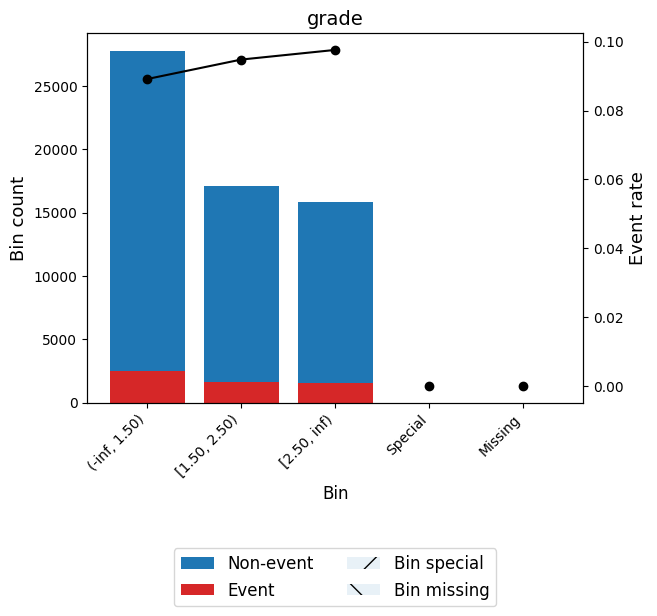

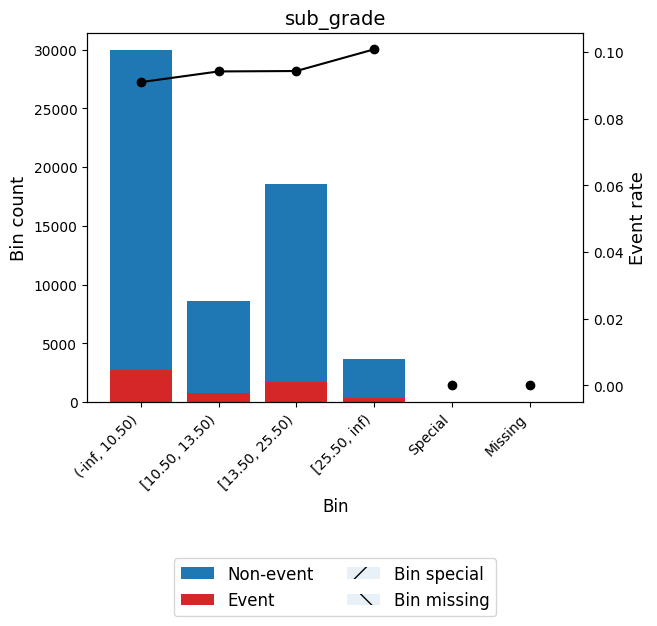

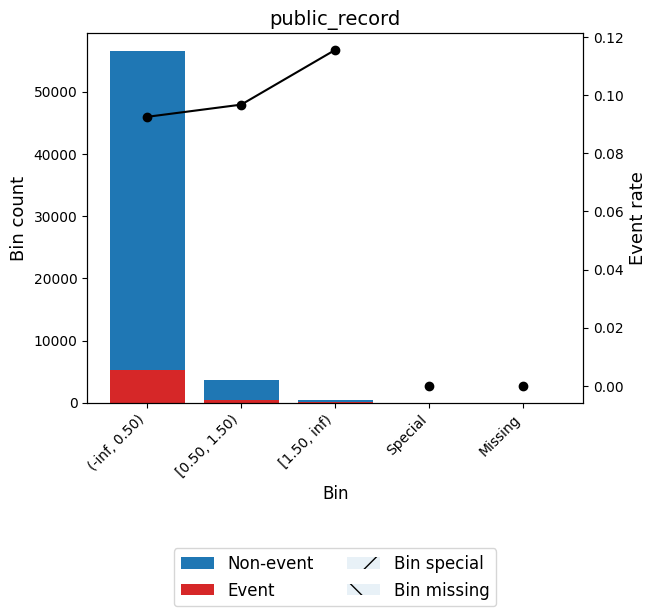

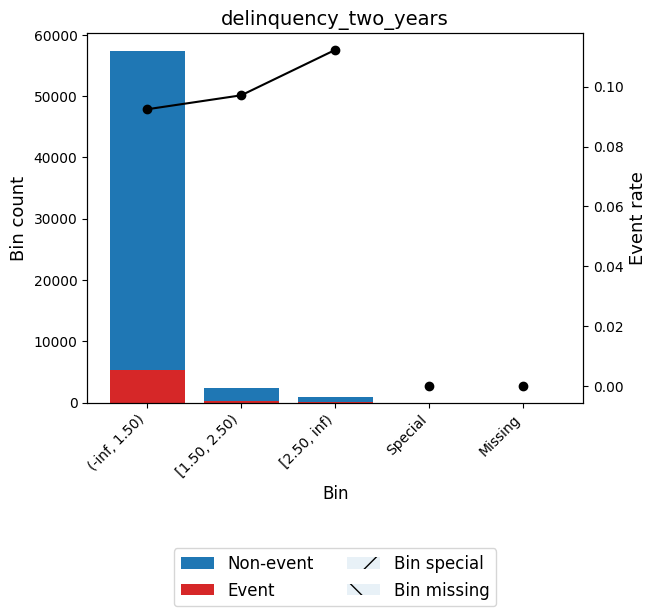

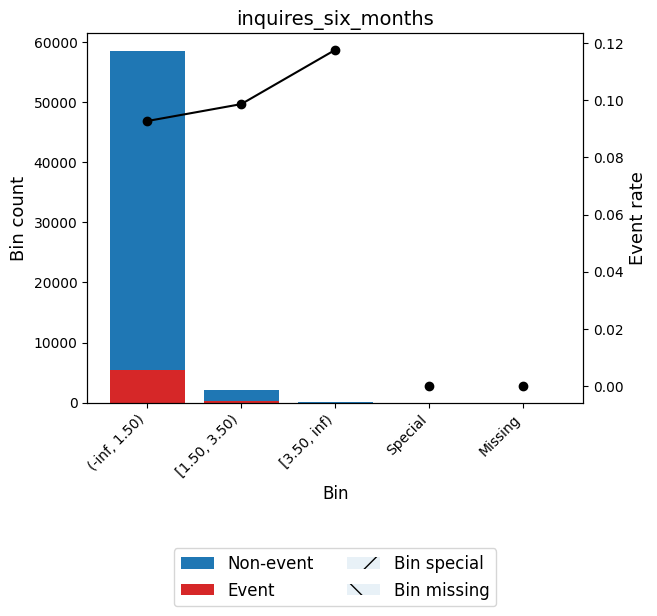

In [59]:
# check out the plot to see the monotonic relationship generated by the new binning
for i, var in enumerate(ordinal_variables):
    t = ordinal_enc.bin_models[var].binning_table
    t.build()
    t.plot(metric='event_rate', show_bin_labels=True)

#### 5.2.3. Nominal variables

For the remaining nominal features, we'll also apply OptBinningTransformer to find the optimal binning for the categories (we'll use transform metric = `indices`). And then apply the Frequency Encoder on top of the new bins.

In [60]:
# set up the binning transformer
nominal_binning =  OptBinningTransformer(features=nominal_variables,
                                         dtype='categorical',            # dtype is categorical for nominal variables
                                         solver='cp',
                                         monotonic_trend='auto',
                                         # user_splits=user_splits,
                                         # user_splits_fixed=user_splits_fixed,
                                         transform_metric='woe')

In [61]:
# apply the binning to the nominal variables
X_train = nominal_binning.fit_transform(X_train, y_train)
X_test = nominal_binning.transform(X_test)

In [62]:
X_train[nominal_variables].head()

,term,batch_enrolled,home_ownership,verification_status,loan_title
26334,0.126725,-0.030875,-0.051542,-0.004626,-0.018546
56981,-0.057621,-0.164230,-0.051542,0.007305,0.035434
53705,-0.057621,0.044626,-0.051542,0.001315,-0.018546
35406,0.126725,0.105653,0.055048,0.007305,-0.018546
66368,-0.057621,0.010852,-0.051542,0.007305,-0.018546


## 6. Continuous variables

### 6.1. Quick inspection
Let's take a look at our continuous variables

In [63]:
len(continuous_vars)

38

In [64]:
# check out the skewness of the distribution 
X_train[continuous_vars].skew().sort_values(ascending=False)

recoveries_collection_fee_prod                  63.945059
total_collection_amount                         12.909639
collection_recovery_fee                         11.308009
received_late_fee_per_account                    9.076931
records_per_open_account                         7.690295
recoveries                                       7.405753
recoveries_collection_fee_total                  7.404031
collection_12_months_medical                     6.593832
current_balance_to_revolving_credit_limit        6.185559
deliquencies_per_open_account                    5.906522
interest_to_debit                                5.324397
total_received_late_fee                          5.067846
inquires_per_open_account                        4.789286
received_interest_per_account                    4.255301
revolving_balance_utilities_prod                 3.507121
funded_to_funded_investor                        3.143339
open_account_to_total_account                    2.991280
revolving_bala

A lot of our continuous variables have right-skewed distribution, let's inspect some of them.

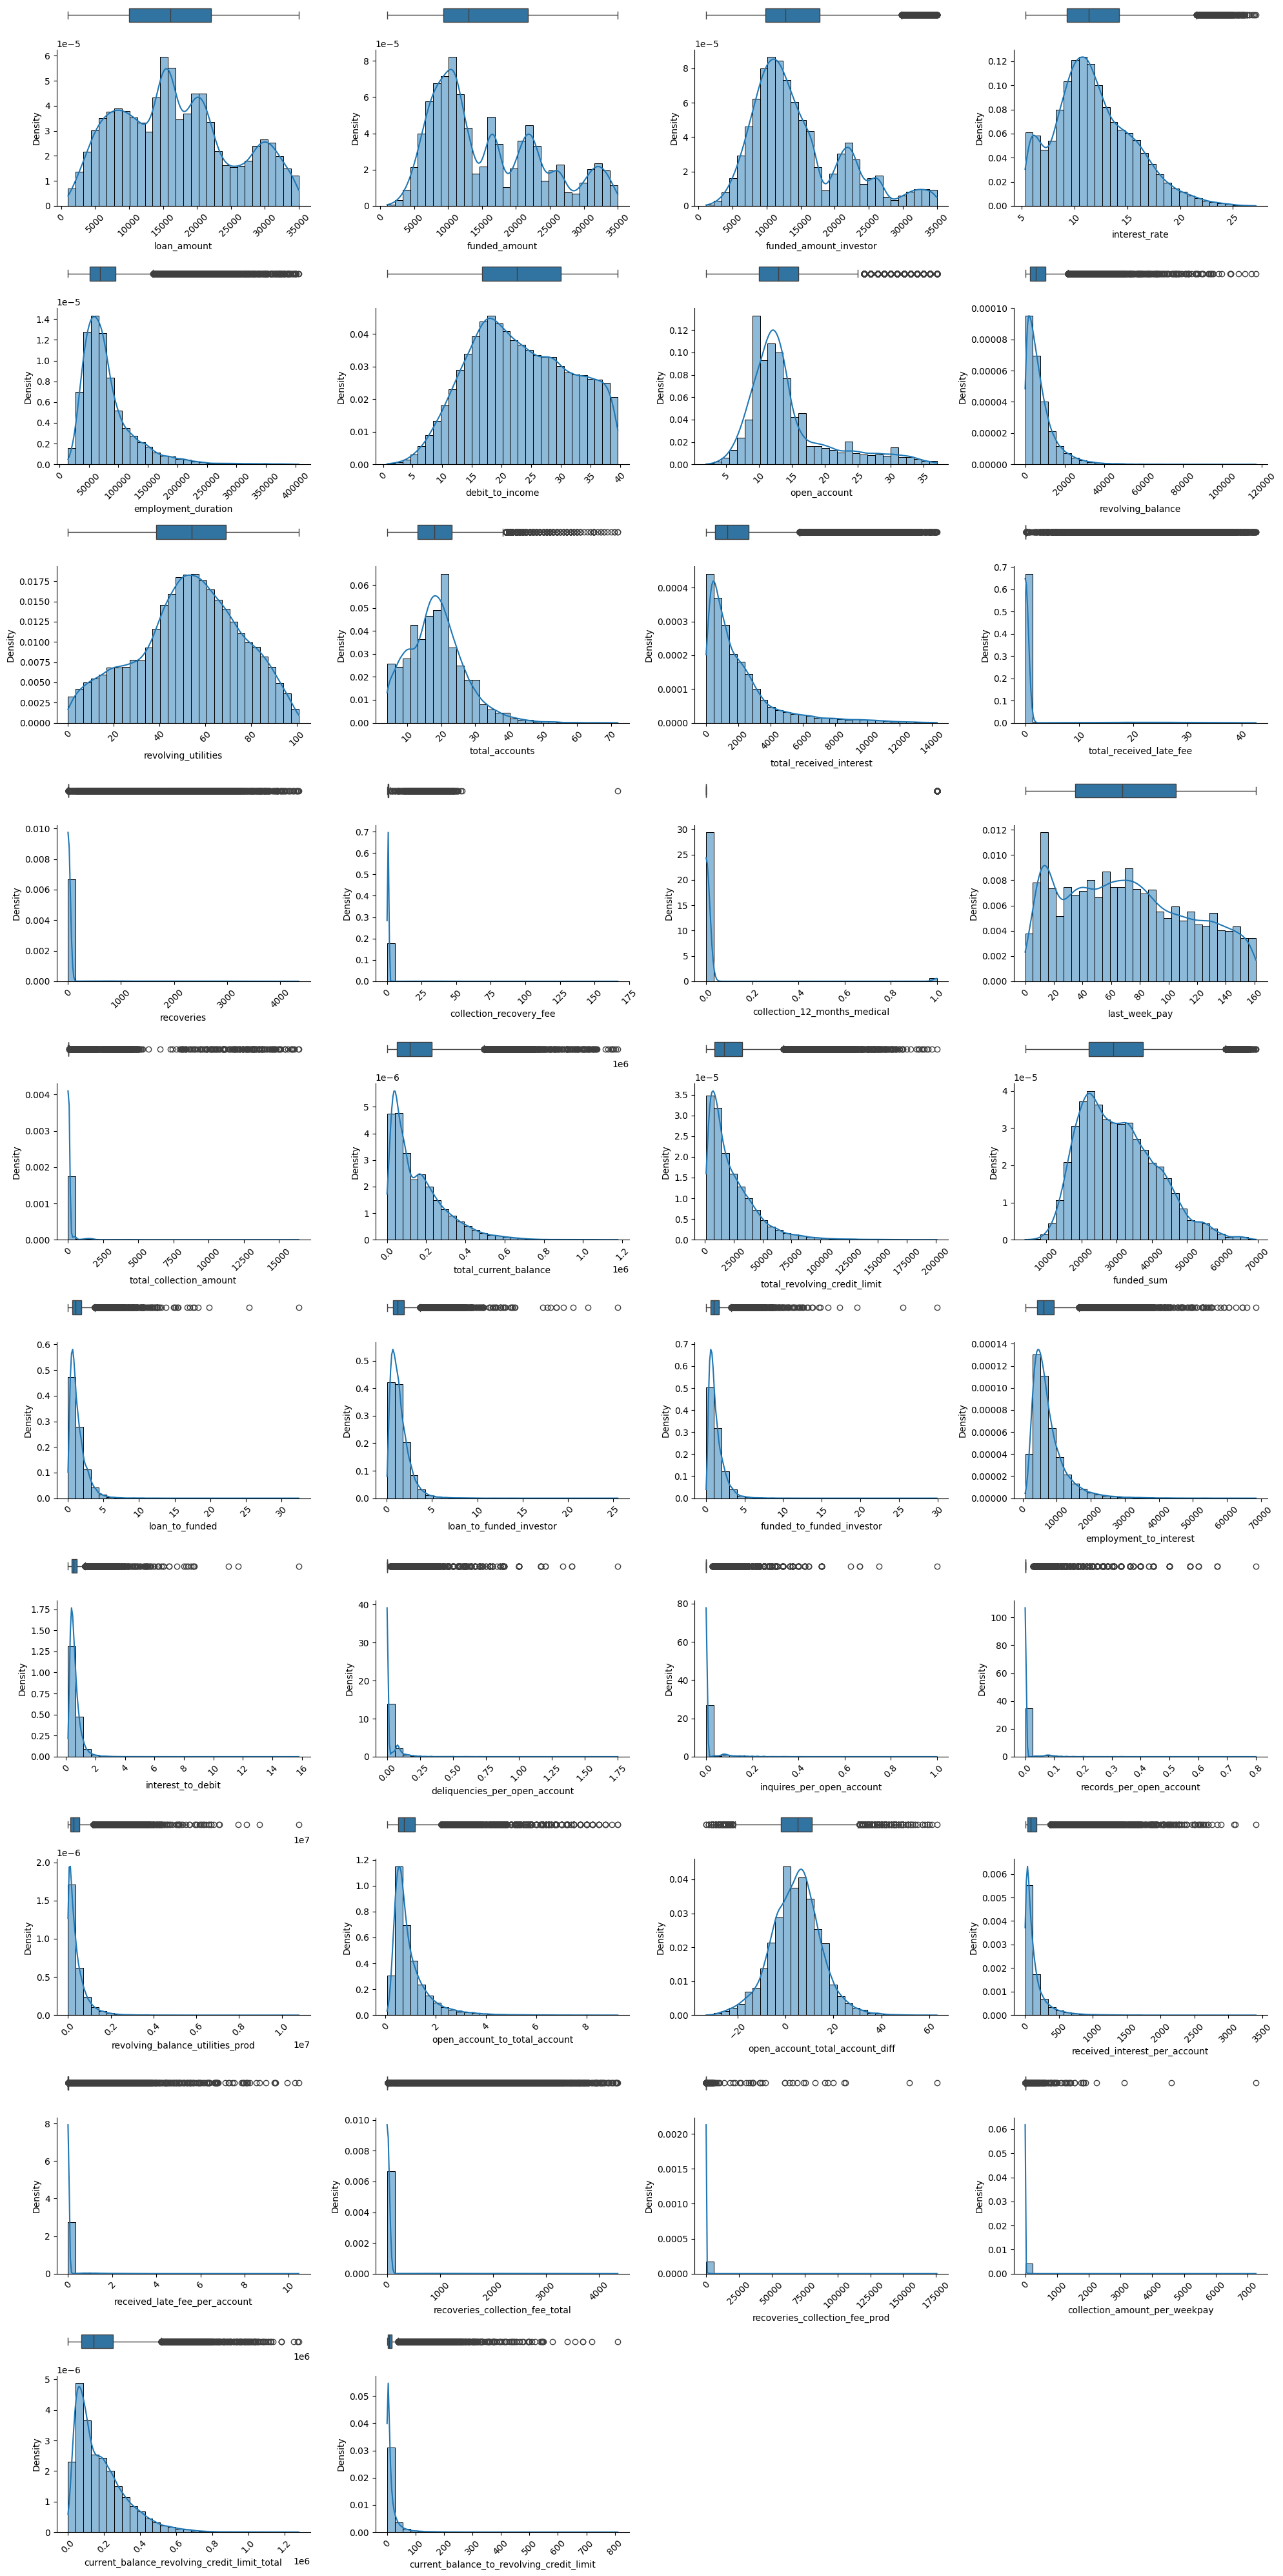

In [65]:
# let's look at the distribution of these variables
fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(20, 40))
ax = ax.ravel()
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

for i, var in enumerate(continuous_vars):
    # Turn off the visible axes in the main subplot
    ax[i].set_visible(False)
    # Create the nested subplots within each cell of the main grid
    gs = ax[i].get_subplotspec().subgridspec(2, 1, height_ratios=[.1, .9])

    # Create boxplot in the first nested subplot, share the x-axis with the histogram
    ax_box = fig.add_subplot(gs[0], sharex=ax[i])
    sns.boxplot(x=X_train[var], ax=ax_box)
    
    # turn off all the ticks on the axes of the box plot
    ax_box.tick_params(left=False, bottom=False)
    # turn off the title on the box plot
    ax_box.set_xlabel('')
    # turn off all spines (edges) around the box plot
    sns.despine(ax=ax_box, left=True, top=True, right=True, bottom=True)

    # Create histogram in the second nested subplot, share x-axis with the boxplot
    ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
    ax_hist.tick_params(axis='x', rotation=45)
    sns.histplot(x=X_train[var], bins=30, kde=True, stat='density', ax=ax_hist)
    # Remove x-axis ticks from the boxplot (to avoid double labels)
    plt.setp(ax_box.get_xticklabels(), visible=False)

    # Remove extra spines
    sns.despine(ax=ax_hist)

# Increase distance between rows
plt.subplots_adjust(hspace=2.0)  # Adjust this value as needed
plt.tight_layout()
plt.show()

We see many continuous variables are (heavily) right-skewed. So, before applying optimal binning and WoE transformation, we'll need to handle the outliers and then apply some transformation to normalize the distributions.

### 6.2. Outlier handling

We'll use the capping method with the lower threshold = 0.01 and upper threshold = 0.99 to handle outliers.

In [66]:
# create OutlierCapper class
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=None, upper_quantile=None):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        self.lower_bound_ = X.quantile(self.lower_quantile)
        self.upper_bound_ = X.quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X[var].clip(lower=self.lower_bound_[var], upper=self.upper_bound_[var])
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [67]:
# create a ColumnTransformer to apply OutlierCapper on our continuous variables

outlier_cap = ColumnTransformer(
    transformers=[
        ('outlier_cap', 
         OutlierCapper(lower_quantile=0.005, upper_quantile=0.995), 
         continuous_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [68]:
# apply outlier capping on the continuous variables
X_train = outlier_cap.fit_transform(X_train, y_train)
X_test = outlier_cap.transform(X_test)

### 6.3. Skewed distribution handling

The majority of numerical variables' distributions are right-skewed and leptokurtic. Therefore, before discretizing them and applying encoding methods (like Weight of Evidence), we need to transform these variables. There are several methods as below:

1. The **logarithmic transformation** is typically used to handle positively skewed distribution by compressing the values. It converts a variable X using the natural logarithm.
$$X' = log(X+c)$$
Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $c$ is a constant added to X to handle cases where $X <= 0$ (commonly set to 1 to avoid taking log of 0)

2. The **Box-Cox transformation** is more flexible than the log transformation because it inlcudes a parameter $\lambda$ that adjusts the transformation depending on the skewness of the distribution.

$$
X' = 
\begin{cases}
\frac{(X^\lambda - 1)}{\lambda} & \text{if } \lambda \neq 0 \\
log(X) & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $\lambda$ is a parameter that can be optimized to best normalize the data

3. The **Yeo-Johnson transformation** is an extension of the Box-Cox transformation that is no longer constrained to positive values.
$$
X' = 
\begin{cases} 
\frac{((X + 1)^{\lambda} - 1)}{\lambda} & \text{if } \lambda \neq 0 \text{ and } X \geq 0 \\ 
-\frac{((-X + 1)^{2 - \lambda} - 1)}{2 - \lambda} & \text{if } \lambda \neq 2 \text{ and } X < 0 \\ 
\ln(X + 1) & \text{if } \lambda = 0 \text{ and } X \geq 0 \\ 
-\ln(-X + 1) & \text{if } \lambda = 2 \text{ and } X < 0 
\end{cases}
$$

In [69]:
# initialize a PowerTransformer to apply Yeo-Johnson transformation
yeojohnson_transformer = ColumnTransformer(
    transformers=[
        ('yeojohnson_transformer', PowerTransformer(method='yeo-johnson', standardize=True), continuous_vars),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [70]:
# apply power transformation on the continuous variables
X_train = yeojohnson_transformer.fit_transform(X_train, y_train)
X_test = yeojohnson_transformer.transform(X_test)

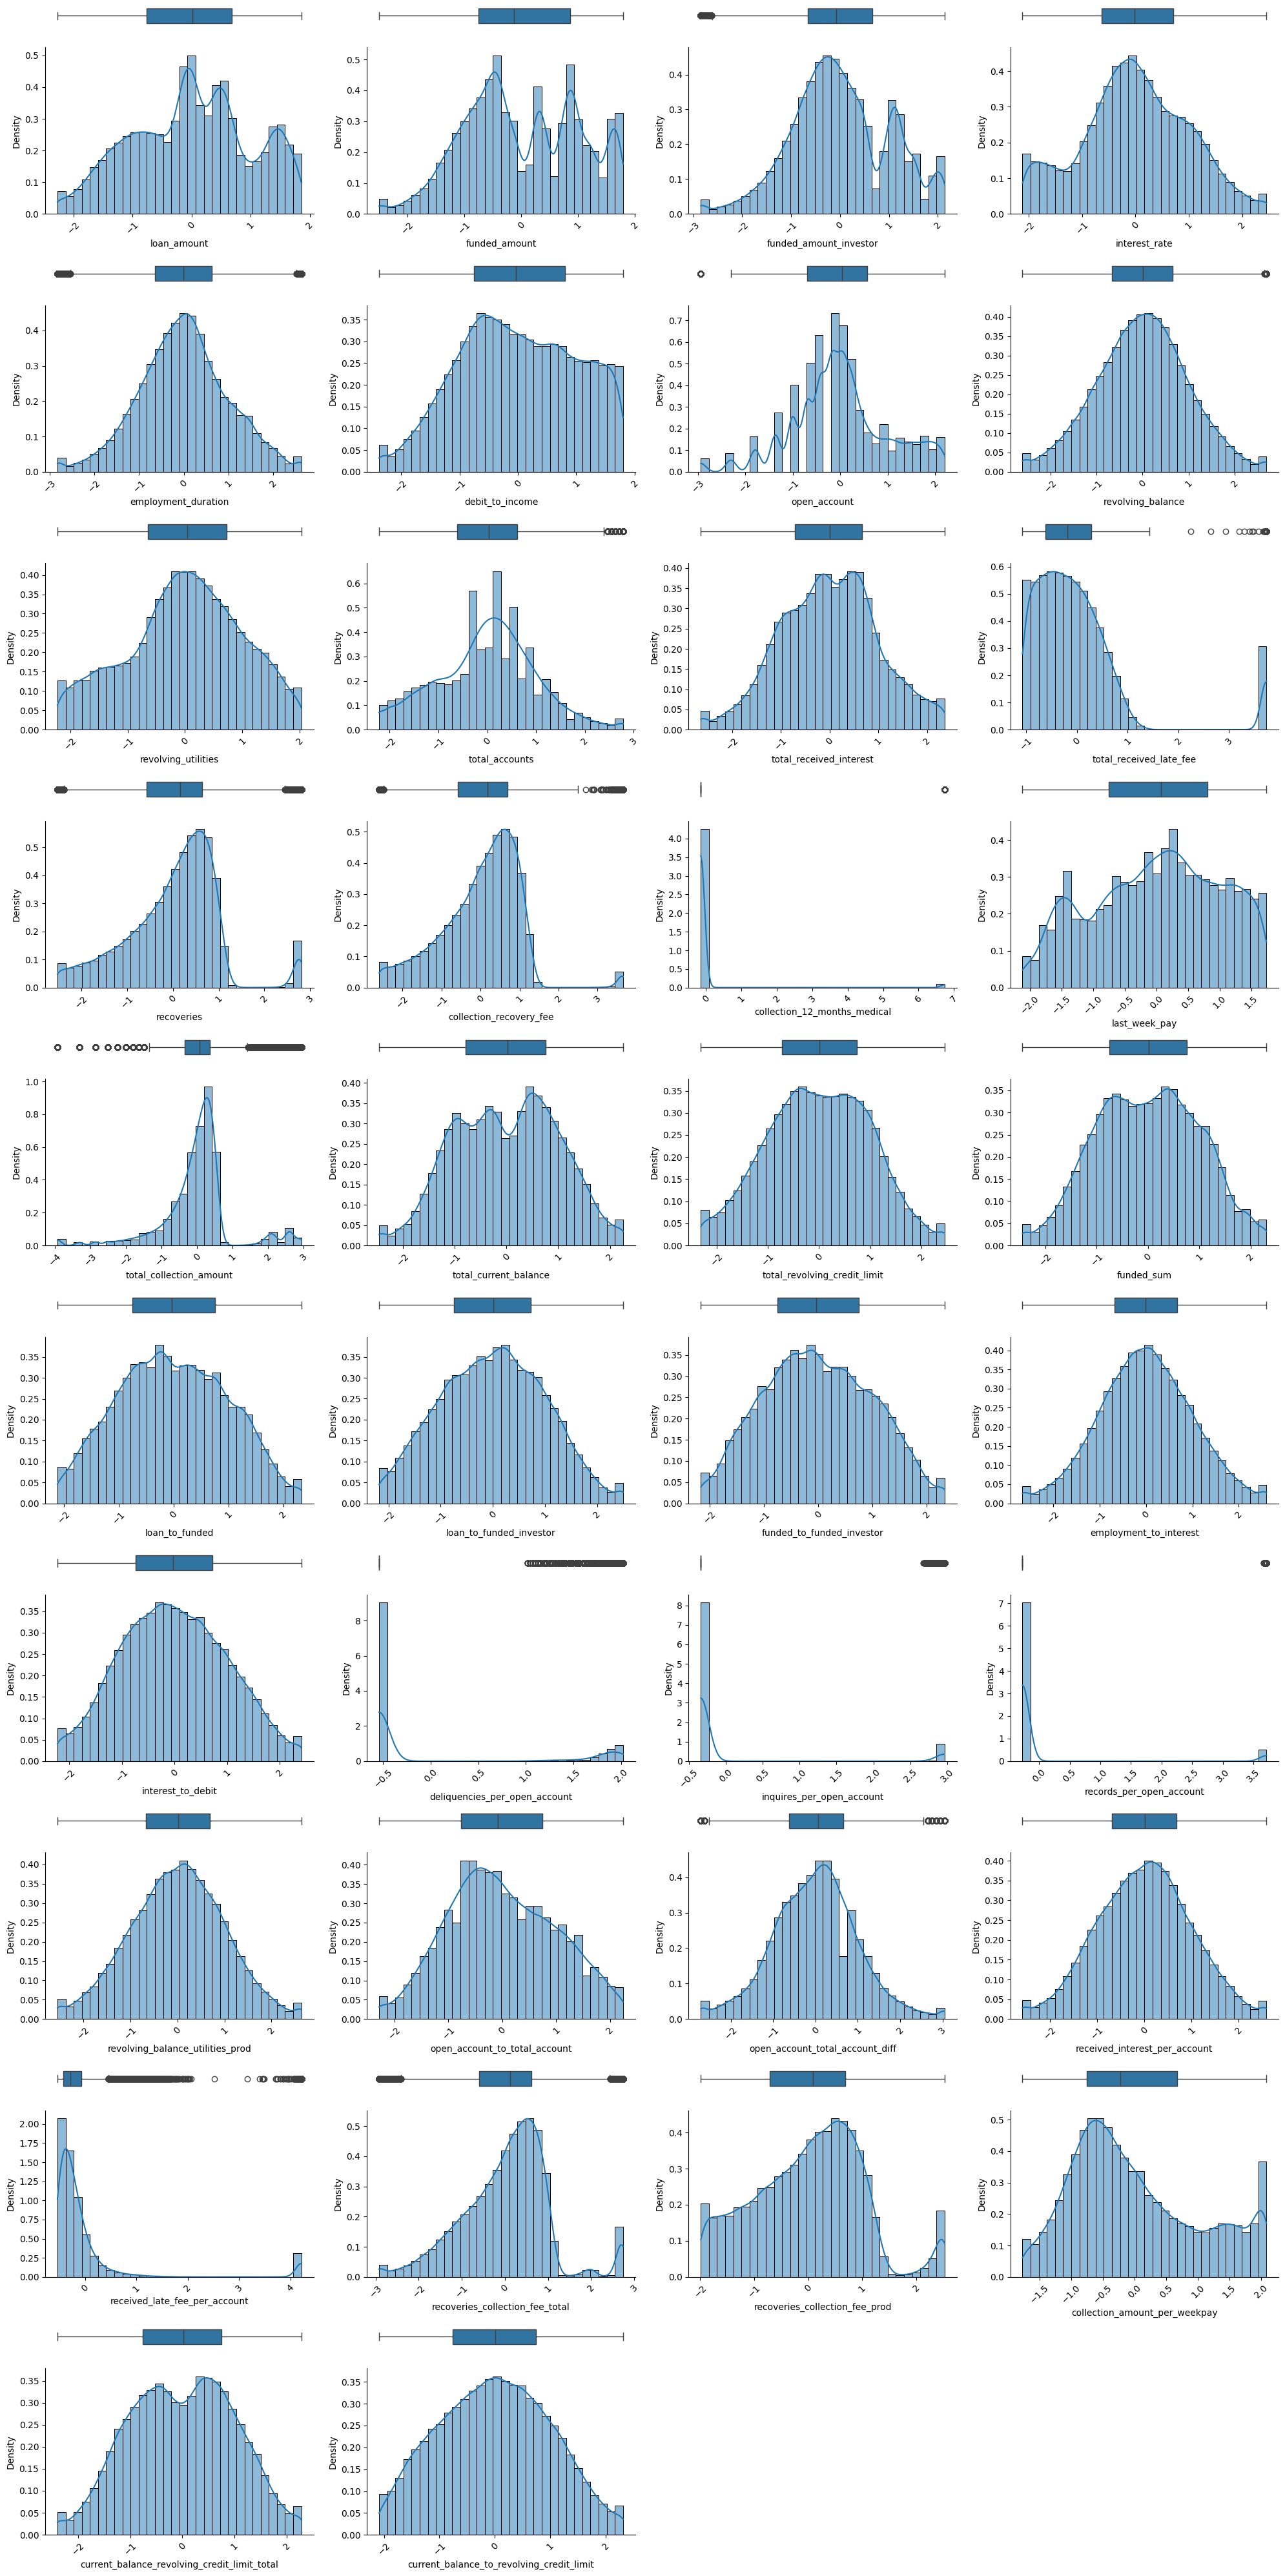

In [71]:
# plot the distribution of the variables after transformation

fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(20, 40))
ax = ax.ravel()
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

for i, var in enumerate(continuous_vars):
    # Turn off the visible axes in the main subplot
    ax[i].set_visible(False)
    # Create the nested subplots within each cell of the main grid
    gs = ax[i].get_subplotspec().subgridspec(2, 1, height_ratios=[.1, .9])

    # Create boxplot in the first nested subplot, share the x-axis with the histogram
    ax_box = fig.add_subplot(gs[0], sharex=ax[i])
    sns.boxplot(x=X_train[var], ax=ax_box)
    
    # turn off all the ticks on the axes of the box plot
    ax_box.tick_params(left=False, bottom=False)
    # turn off the title on the box plot
    ax_box.set_xlabel('')
    # turn off all spines (edges) around the box plot
    sns.despine(ax=ax_box, left=True, top=True, right=True, bottom=True)

    # Create histogram in the second nested subplot, share x-axis with the boxplot
    ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
    ax_hist.tick_params(axis='x', rotation=45)
    sns.histplot(x=X_train[var], bins=30, kde=True, stat='density', ax=ax_hist)
    # Remove x-axis ticks from the boxplot (to avoid double labels)
    plt.setp(ax_box.get_xticklabels(), visible=False)

    # Remove extra spines
    sns.despine(ax=ax_hist)

# Increase distance between rows
plt.subplots_adjust(hspace=2.0)  # Adjust this value as needed
plt.tight_layout()
plt.show()

In [72]:
X_train[continuous_vars].head()

,loan_amount,funded_amount,funded_amount_investor,interest_rate,employment_duration,debit_to_income,open_account,revolving_balance,revolving_utilities,total_accounts,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,funded_sum,loan_to_funded,loan_to_funded_investor,funded_to_funded_investor,employment_to_interest,interest_to_debit,deliquencies_per_open_account,inquires_per_open_account,records_per_open_account,revolving_balance_utilities_prod,open_account_to_total_account,open_account_total_account_diff,received_interest_per_account,received_late_fee_per_account,recoveries_collection_fee_total,recoveries_collection_fee_prod,collection_amount_per_weekpay,current_balance_revolving_credit_limit_total,current_balance_to_revolving_credit_limit
26334,-0.354680,0.810123,1.561567,1.930328,-1.686567,-0.181193,0.405373,-0.701717,1.780425,0.387205,-1.069937,0.032174,0.432822,-0.286794,-0.148324,-1.792438,-0.167832,-0.638275,-0.578459,1.510812,-0.770352,-1.128908,-0.439871,-2.526751,1.186340,-0.542269,-0.338838,-0.269597,-0.096477,-0.124941,0.153846,-1.167638,-0.257497,0.343889,0.236092,1.588123,-0.842809,-0.057846
56981,-0.672783,-1.103750,-0.734257,-1.720106,0.603494,-0.411787,-0.692623,-0.580377,0.937621,0.272182,0.046432,-1.014128,-0.300429,0.519620,-0.148324,-0.531543,-0.396327,-1.810789,-1.270752,-1.400793,0.329828,-0.046589,-0.423517,1.448214,-0.960212,-0.542269,-0.338838,-0.269597,-0.154281,-0.769731,0.550422,-0.083703,-0.522352,-0.265032,0.036465,-0.200313,-2.214604,-0.670403
53705,-0.352379,-1.367025,-0.637710,-0.533959,-1.162279,0.373635,0.036370,0.834663,0.883788,0.272182,0.546667,-0.070120,0.793314,-1.987585,-0.148324,-1.906483,0.570699,0.253339,0.203654,-1.494560,0.836905,0.190923,-0.712737,-0.661853,-0.700135,-0.542269,-0.338838,-0.269597,1.172124,-0.295828,0.252815,0.358786,-0.274240,0.670175,-0.796728,1.933771,0.203148,0.054992
35406,-1.974333,-0.347128,-0.159735,0.559209,-2.149644,-0.602738,-0.419885,-2.100725,-1.329064,1.513777,-0.456636,-0.296274,0.574375,-0.040106,-0.148324,-1.384211,-2.508284,2.028479,0.903377,-0.530551,-1.599646,-1.744066,-0.183659,-2.112823,0.789293,-0.542269,-0.338838,-0.269597,-2.154653,-1.413167,1.647593,-0.906147,-0.412502,0.519494,0.507462,-0.710804,2.087063,0.669157
66368,-0.162507,0.858816,0.517304,-0.617540,-0.117627,0.596766,0.036370,0.180318,0.733308,0.272182,0.937313,0.402837,-0.009134,-0.942311,-0.148324,-0.667744,-0.090219,-0.726362,-0.237516,0.832455,-0.665882,-0.412452,0.326268,0.224042,-0.906939,-0.542269,-0.338838,-0.269597,0.516234,-0.295828,0.252815,0.692816,-0.126968,-0.223481,-0.576832,0.209760,-0.872220,-0.409678


In [73]:
# inspect the data shape after transformation
X_train.shape, X_test.shape

((60716, 52), (6747, 52))

In [74]:
# let's also save our preprocessed train dataset
X_train.to_csv('./data/X_train.csv', index=False)
y_train.to_csv('./data/y_train.csv', index=False)

X_test.to_csv('./data/X_test.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

## 7. Modeling

Now that we have preprocessed our data, let's see which variables are most important for predicting loan default.

### 7.1. Feature selection

In [75]:
# load the processed variables and target
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')

In [76]:
X_train.shape, X_test.shape

((60716, 52), (6747, 52))

In [77]:
# check the number of each classes in the train and test set
print('Train set')
print(y_train['loan_status'].value_counts())

print('Test set')
print(y_test['loan_status'].value_counts())

Train set
loan_status
0    55071
1     5645
Name: count, dtype: int64
Test set
loan_status
0    6151
1     596
Name: count, dtype: int64


First, we'll try to remove correlated features.

In [78]:
# logistic regression model
lr = LogisticRegression(C=0.1, max_iter=1000, random_state=42)

# correlation selector
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.5,    # (absolute) correlation coefficient threshold
    missing_values="raise",
    selection_method="model_performance",
    estimator=lr,
    scoring="roc_auc",
    cv=5,
)

# this may take a while, because we are training
# a random forest per correlation group

sel.fit(X_train, y_train)

SmartCorrelatedSelection(cv=5,
                         estimator=LogisticRegression(C=0.1, max_iter=1000,
                                                      random_state=42),
                         missing_values='raise',
                         selection_method='model_performance', threshold=0.5)

In [79]:
sel.correlated_feature_sets_

[{'any_delinquency_two_years', 'deliquencies_per_open_account'},
 {'any_inquires_six_months',
  'inquires_per_open_account',
  'inquires_six_months'},
 {'any_public_record', 'public_record', 'records_per_open_account'},
 {'collection_amount_per_weekpay', 'last_week_pay', 'total_collection_amount'},
 {'collection_recovery_fee', 'recoveries_collection_fee_prod'},
 {'current_balance_revolving_credit_limit_total',
  'current_balance_to_revolving_credit_limit',
  'total_current_balance'},
 {'debit_to_income', 'interest_to_debit'},
 {'employment_duration', 'employment_to_interest'},
 {'funded_amount',
  'funded_sum',
  'funded_to_funded_investor',
  'loan_to_funded'},
 {'funded_amount_investor', 'loan_to_funded_investor'},
 {'open_account',
  'open_account_to_total_account',
  'open_account_total_account_diff'},
 {'received_interest_per_account', 'total_received_interest'},
 {'received_late_fee_per_account', 'total_received_late_fee'},
 {'recoveries', 'recoveries_collection_fee_total'},
 {'r

In [80]:
# the transformer retains 1 best performing feature from each group of correlated feature
# the rest will be dropped
sel.features_to_drop_

['any_delinquency_two_years',
 'any_inquires_six_months',
 'inquires_six_months',
 'any_public_record',
 'public_record',
 'collection_amount_per_weekpay',
 'last_week_pay',
 'recoveries_collection_fee_prod',
 'current_balance_to_revolving_credit_limit',
 'total_current_balance',
 'debit_to_income',
 'employment_to_interest',
 'funded_amount',
 'funded_sum',
 'funded_to_funded_investor',
 'funded_amount_investor',
 'open_account_to_total_account',
 'open_account_total_account_diff',
 'total_received_interest',
 'total_received_late_fee',
 'recoveries_collection_fee_total',
 'revolving_balance']

In [81]:
# drop correlated features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((60716, 30), (6747, 30))

After removing correlated features, we can proceed with training our model.

In this circumstances, as all the people would have less than 50% of probability to be a defaulter, any model would predict only 0s. Metrics like accuracy score, precision, f1 score, recall and AUC wouldn't be effective for this problem. Because of this, the organizers of the hackathon chose a metric based on the probability of a person to be a defaulter or not. The metric chosen was the log-loss metric. 

Formula for calculating log-loss:
$$\frac {-\sum_{i=1}^N w_i(c_i log(p_i) + (1-c_i)log(1-p_i))}{\sum_{i=1}^N w_i}$$

In reality, however, AUC or its rescaled version, Gini, is used more often for assessing the discriminatory power of a default prediction model. Therefore, in this project, we will also use log-loss as our metric to compare different models' performance in addition to AUC score, but during training and hyperparameter optimization, we will try to maximize AUC score.

Formula for calculating AUC score, expressed by the Wilcoxon-Mann-Whitney statistic:
$$\text{AUC}(f) = \frac{\sum_{t_0\in\mathcal{D}^0}\sum_{t_1\in\mathcal{D}^1}1[f(t_0) < f(t_1)]}{|\mathcal{D}^0|\cdot|\mathcal{D}^1|}$$
where $1[f(t_0) < f(t_1)]$ denotes an indicator function which returns 1 if $f(t_0) < f(t_1)$ otherwise return 0

In credit scoring, the Gini coefficient, which is a rescaled version of AUC is often used:
$$\text{Gini} = 2\text{AUC} - 1$$

### 7.2. Benchmark model - Logistic regression

We'll start with a simple Logistic regression model and use it as a benchmark to compare against other classifier.

In [82]:
# define the model
lr = LogisticRegression(penalty='l1', 
                        C=10.0, 
                        solver='saga', 
                        random_state=42, 
                        max_iter=1000,
                       n_jobs=-1)

# hyperparameter space - we'll end up with 6 trials
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[1.0, 5.0, 10.0],
)

# Stratified K-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# set up grid search to find best hyperparameters
clf = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='roc_auc',               # we're minimizing log-loss (or maximizing the negative log-loss)
    cv=kf,
    refit=False,                           # refit the best model to entire dataset
)

In [83]:
# perform the search - this will take some time
search = clf.fit(X_train, y_train)

In [84]:
# see the best hyperparameters
search.best_params_

{'C': 5.0, 'penalty': 'l1'}

In [85]:
# check out the best score (roc-auc) achieved in cross validation
search.best_score_

0.5441539253050189

In [86]:
# check out the mean and standard deviation of scoring metric with different trials
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.head()

,params,mean_test_score,std_test_score
0,"{'C': 1.0, 'penalty': 'l1'}",0.543653,0.008532
1,"{'C': 1.0, 'penalty': 'l2'}",0.543888,0.008507
2,"{'C': 5.0, 'penalty': 'l1'}",0.544154,0.008579
3,"{'C': 5.0, 'penalty': 'l2'}",0.544067,0.008641
4,"{'C': 10.0, 'penalty': 'l1'}",0.544047,0.008644


Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [87]:
model = LogisticRegression(solver='saga',  
                           max_iter=1000,
                           n_jobs=-1,
                          **search.best_params_)

# Stratified K-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
roc_auc = []
log_losses = []
i = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities for log loss calculation
    y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

    # calculate roc-auc for this fold
    fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
    roc_auc.append(fold_auc)

    # calculate log-loss for this fold
    fold_logloss = log_loss(y_fold_val, y_pred_proba)
    log_losses.append(fold_logloss)

    print(f'Fold {i}: roc_auc={fold_auc:.4f}, log_loss={fold_logloss:.4f}')
    i+=1

# return mean roc auc across all folds
avg_roc_auc = np.mean(roc_auc)
# return mean logloss across all folds
avg_logloss = np.mean(log_losses)

Fold 1: roc_auc=0.5350, log_loss=0.3089
Fold 2: roc_auc=0.5570, log_loss=0.3079
Fold 3: roc_auc=0.5389, log_loss=0.3088
Fold 4: roc_auc=0.5431, log_loss=0.3083
Fold 5: roc_auc=0.5400, log_loss=0.3086


In [88]:
# Compare the performance of the model on validation folds and test set
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Validation Log-loss: {avg_logloss:.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Validation roc-auc: {avg_roc_auc:.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Validation Log-loss: 0.3085
Test Log-loss: 0.2973
Validation roc-auc: 0.5428
Test roc-auc: 0.5531


The roc-auc score on both the validation and test set is larger than 0.5, which means our model performs better than a random model. 

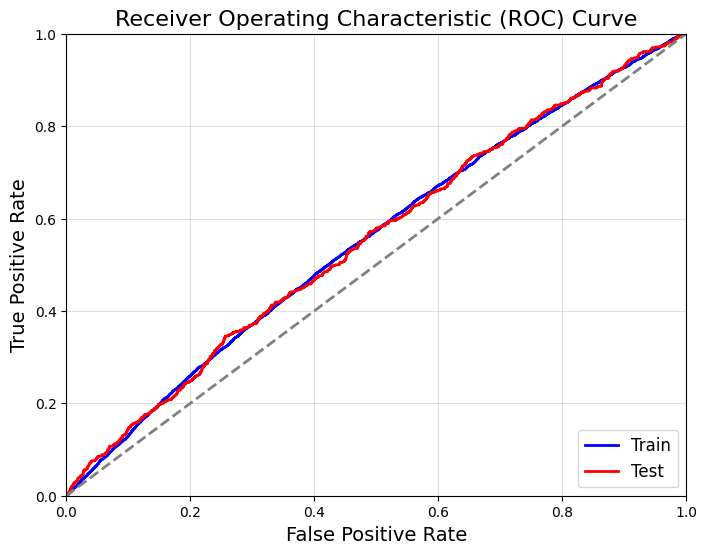

In [89]:
# Compute ROC curve and AUC on the train set and test set
train_preds = model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, train_preds)
fpr_test, tpr_test, _ = roc_curve(y_test, test_preds)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
# for train
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.4)
plt.show()

We can also assess feature importance by accessing the feature coefficients.

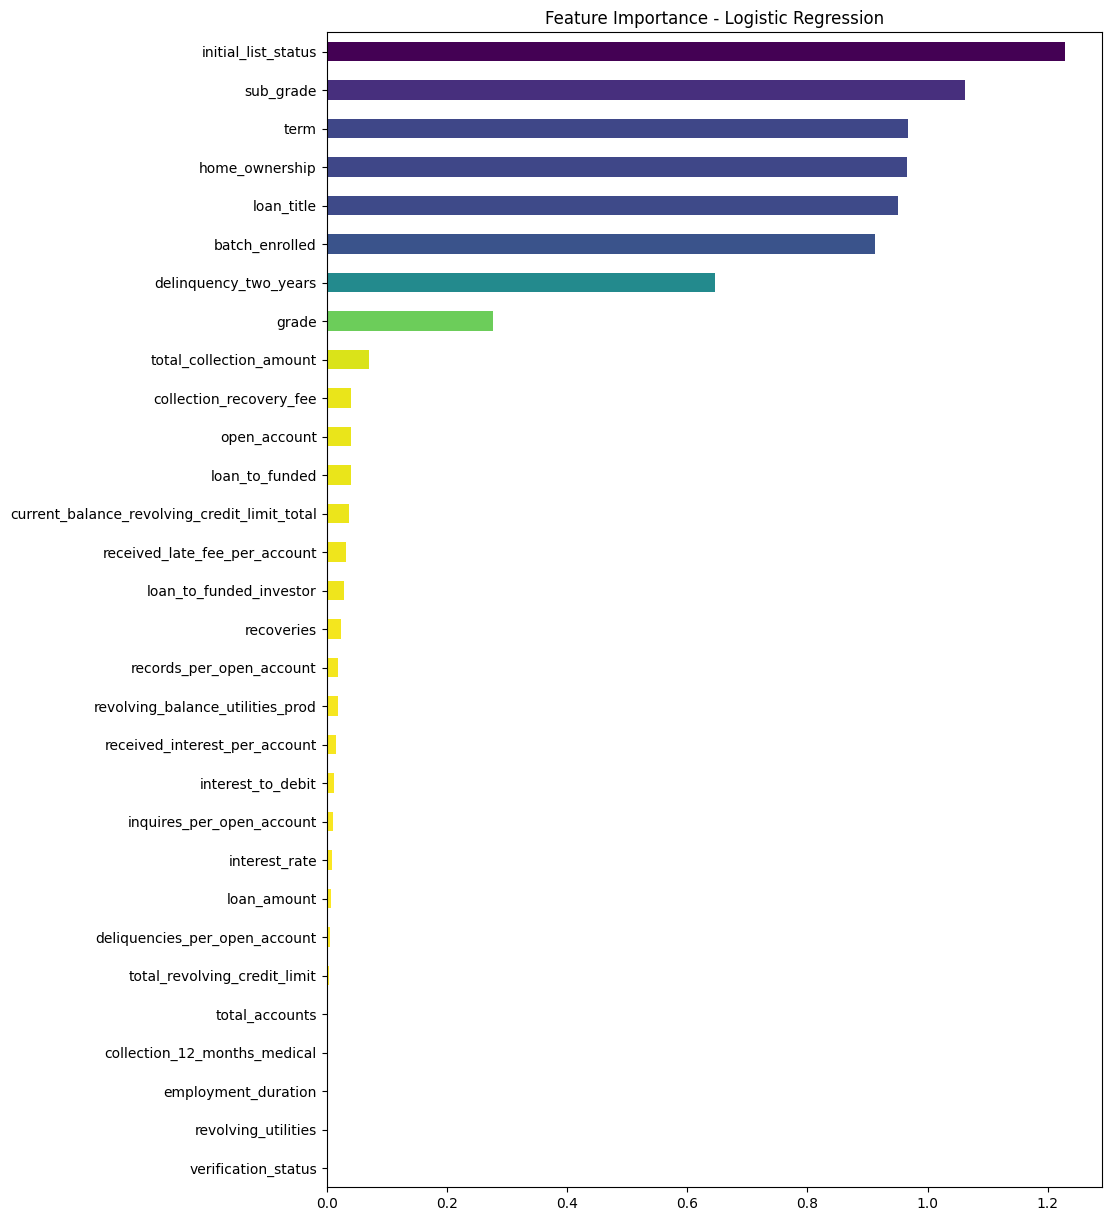

In [90]:
feature_coef = model.coef_[0]
feature_importance = pd.Series(feature_coef, index=X_train.columns)

# Create a colormap
cmap = plt.get_cmap("viridis_r")

# Normalize the importance values to be between 0 and 1 for color mapping
norm = plt.Normalize(feature_importance.abs().min(), feature_importance.abs().max())

# Create a color array based on the normalized importance
colors = [cmap(norm(value)) for value in feature_importance.abs().sort_values()]

# plot feature importances from highest to lowest
feature_importance.abs().sort_values().plot(kind='barh', figsize=(10, 15), color=colors)
plt.title('Feature Importance - Logistic Regression')
plt.show()

Since the final logistic regression model uses L1 regularization, some of the features' coefficients are shrink to (almost) 0. The top 7 features are: `initial_list_status`, `term`, `batch_enrolled`, `home_ownership`, `loan_title`, `delinquency_two_years`, `sub_grade`, `grade`.

In [91]:
# save this model
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In addition to examining the variables' coefficient, we can also look at SHAP values, or Shapely Additive Explanation, which  represents how much a feature contribute to the difference between the model's prediction for a specific instance and the average model prediction across all instances.

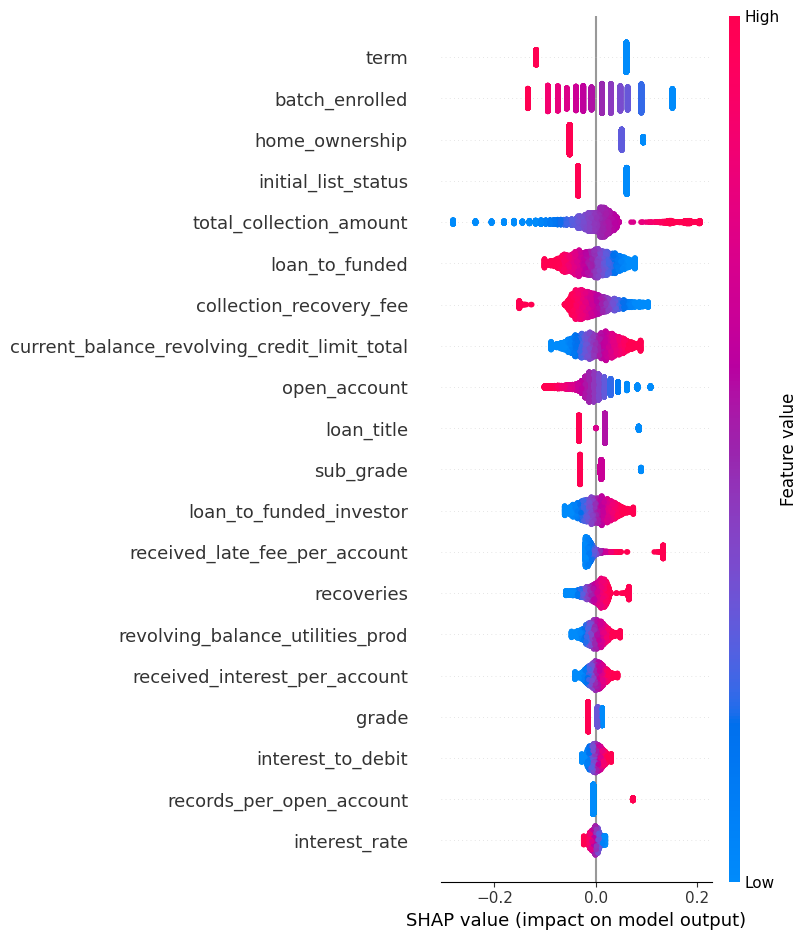

In [92]:
import shap

with open('lr_model.pkl', 'rb') as file:
    lr = pickle.load(file)

explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)

# plot the shap values
shap.summary_plot(shap_values, X_test)

### 7.3. Challenger models

The logistic regression model assumes a linear relationship between each of the variable and the target variable. In the logistic regression model above, we saw that the features that have been WOE-encoded with a monotonic trend tend to have high importance. Let's see if there are other predictive features that is not linearly correlated with the target using non-linear models.

In [93]:
X_train.shape, X_test.shape

((60716, 30), (6747, 30))

Let's play with some hyperparameter tuning using our feature subset. We'll set our metric to be optimized to be Logloss. We will use `optuna` to define an objective function to be optimized.

#### 7.3.1. Random Forest Classifier

In [94]:
def objective(trial):
    # set up the parameters for the LGBM classifier
    param = {
        'criterion': 'log_loss',
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.12, 0.2),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.08, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'random_state': 42,
    }
    # create a model with the parameters
    model = RandomForestClassifier(**param)

    # Stratified K-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    roc_auc = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # calculate roc-auc for this fold
        fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_auc.append(fold_auc)

    # return mean roc auc across all folds
    avg_roc_auc = np.mean(roc_auc)
    return avg_roc_auc
    # return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [95]:
# create a study
study = optuna.create_study(
    study_name='rf_study',   # name for our study
    direction="maximize",      # we are trying to maximize roc-auc
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 20
try:
    study.optimize(objective, n_trials=20)
except:
    raise

[I 2024-11-16 20:14:22,248] A new study created in memory with name: rf_study
[I 2024-11-16 20:16:07,722] Trial 0 finished with value: 0.5390485938864356 and parameters: {'n_estimators': 750, 'min_samples_split': 0.17528296036360458, 'min_samples_leaf': 0.08489236762723927, 'max_depth': 6}. Best is trial 0 with value: 0.5390485938864356.
[I 2024-11-16 20:17:22,352] Trial 1 finished with value: 0.538749939926084 and parameters: {'n_estimators': 549, 'min_samples_split': 0.18183929782229855, 'min_samples_leaf': 0.08219447241048866, 'max_depth': 9}. Best is trial 0 with value: 0.5390485938864356.
[I 2024-11-16 20:19:22,080] Trial 2 finished with value: 0.5391481562820203 and parameters: {'n_estimators': 890, 'min_samples_split': 0.1857427474047268, 'min_samples_leaf': 0.08710216771489963, 'max_depth': 9}. Best is trial 2 with value: 0.5391481562820203.
[I 2024-11-16 20:21:25,997] Trial 3 finished with value: 0.5389646785228621 and parameters: {'n_estimators': 958, 'min_samples_split': 0.1

In [96]:
# examine the best parameters found during the trials
study.best_params

{'n_estimators': 873,
 'min_samples_split': 0.12173328524403806,
 'min_samples_leaf': 0.08924314553594508,
 'max_depth': 8}

In [97]:
study.best_value

0.539244414726216

In [98]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,0,0.539049,2024-11-16 20:14:22.250517,2024-11-16 20:16:07.722299,0 days 00:01:45.471782,6,0.084892,0.175283,750,COMPLETE
1,1,0.538750,2024-11-16 20:16:07.723712,2024-11-16 20:17:22.351911,0 days 00:01:14.628199,9,0.082194,0.181839,549,COMPLETE
2,2,0.539148,2024-11-16 20:17:22.353379,2024-11-16 20:19:22.079886,0 days 00:01:59.726507,9,0.087102,0.185743,890,COMPLETE
3,3,0.538965,2024-11-16 20:19:22.081070,2024-11-16 20:21:25.996866,0 days 00:02:03.915796,8,0.098451,0.168106,958,COMPLETE
4,4,0.538514,2024-11-16 20:21:25.998262,2024-11-16 20:22:30.741929,0 days 00:01:04.743667,7,0.096866,0.189942,515,COMPLETE


Let's see how the model with the best parameter performs on the train and test set.

In [99]:
study.best_params

{'n_estimators': 873,
 'min_samples_split': 0.12173328524403806,
 'min_samples_leaf': 0.08924314553594508,
 'max_depth': 8}

In [100]:
# save the best params to a json file
with open('rf_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)
    # json.dump(study.best_trials[0].params, file, indent=4)

In [101]:
# retrieve the best parameters from the study
with open('rf_params.json', 'r') as file:
    best_rf_params = json.load(file)


best_rf_params

{'n_estimators': 873,
 'min_samples_split': 0.12173328524403806,
 'min_samples_leaf': 0.08924314553594508,
 'max_depth': 8}

In [102]:
# create a model with the parameters and fit it
model = RandomForestClassifier(criterion='log_loss',
                               **best_rf_params)


# Stratified K-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
roc_auc = []
log_losses = []
i = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities for log loss calculation
    y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

    # calculate roc-auc for this fold
    fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
    roc_auc.append(fold_auc)

    # calculate log-loss for this fold
    fold_logloss = log_loss(y_fold_val, y_pred_proba)
    log_losses.append(fold_logloss)

    print(f'Fold {i}: roc_auc={fold_auc:.4f}, log_loss={fold_logloss:.4f}')
    i+=1

# return mean roc auc across all folds
avg_roc_auc = np.mean(roc_auc)
# return mean logloss across all folds
avg_logloss = np.mean(log_losses)

Fold 1: roc_auc=0.5357, log_loss=0.3089
Fold 2: roc_auc=0.5484, log_loss=0.3089
Fold 3: roc_auc=0.5381, log_loss=0.3089
Fold 4: roc_auc=0.5315, log_loss=0.3090
Fold 5: roc_auc=0.5364, log_loss=0.3090


Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [103]:
# let's get the predictions
# train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Validation Log-loss: {avg_logloss:.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Validation roc-auc: {avg_roc_auc:.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Validation Log-loss: 0.3089
Test Log-loss: 0.2982
Validation roc-auc: 0.5380
Test roc-auc: 0.5581


Let's explore feature importance for the RandomForest classifier

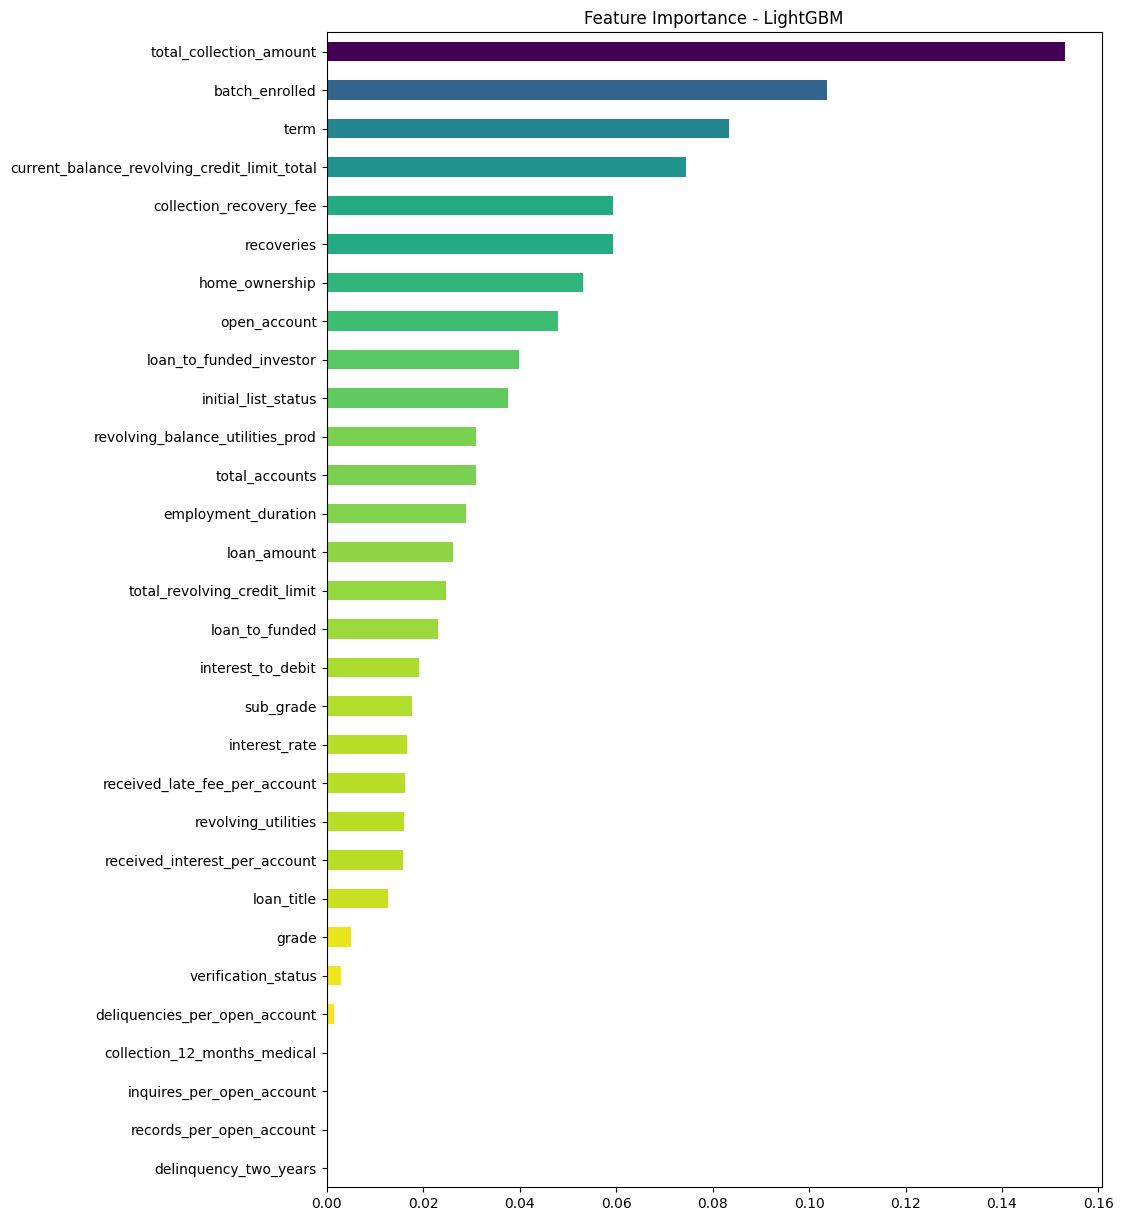

In [104]:
feature_coef = model.feature_importances_
feature_importance = pd.Series(feature_coef, index=X_train.columns)

# Create a colormap
cmap = plt.get_cmap("viridis_r")

# Normalize the importance values to be between 0 and 1 for color mapping
norm = plt.Normalize(feature_importance.abs().min(), feature_importance.abs().max())

# Create a color array based on the normalized importance
colors = [cmap(norm(value)) for value in feature_importance.abs().sort_values()]

# plot feature importances from highest to lowest
feature_importance.abs().sort_values().plot(kind='barh', figsize=(10, 15), color=colors)
plt.title('Feature Importance - LightGBM')
plt.show()

With the `RandomForestClassifier`, we did achieve higher ROC-AUC score. We also see similar performance (log-loss and AUC) on the validation set and the test set, meaning we did not overfit to any validation fold during training.

Additionally, with this model, `total_collection_amount` appears to be the most important feature. `term`, `batch_enrolled`, and `home_ownership` are still among the top important features. Some numerical features like `collection_recovery_fee`, `current_balance_revolving_credit_limit_total`, and `collection_recovery_fee`, and `recoveries` are also among the top features, which means with a non-linear model, these features have higher predictive power.

In [105]:
# save this model
import pickle
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 7.3.2. Light GBM Classifier

In [106]:
def objective(trial):
    # set up the parameters for the LGBM classifier
    param = {
        'metric': 'auc',
        'lambda_l1': trial.suggest_categorical('reg_lambda', [0.1, 1.0, 3.0, 5.0, 10.0]),            # l1 regularization
        'lambda_l2': trial.suggest_categorical('reg_alpha', [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]),          # l2 regularization
        'min_gain_to_split': trial.suggest_categorical('min_gain_to_split', [0.1, 0.3, 0.5, 1.0]),
        'max_bin': trial.suggest_categorical('max_bin', [32, 64, 128, 256]),
        'bagging_fraction': trial.suggest_categorical('bagging_fraction', [0.3, 0.4, 0.5, 0.6]),
        'baggin_freq': trial.suggest_int('baggin_freq', 1, 5),
        'feature_fraction': trial.suggest_categorical('feature_fraction', [0.3, 0.5, 0.75, 0.9]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014]),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000, step=25),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256, step=16),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200, step=10),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'random_state': 42,
        'verbose': -1, 
        'early_stopping_round': 20
    }
    # create a model with the parameters
    model = LGBMClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    roc_auc=[]

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train,
                 eval_set=[(X_fold_val, y_fold_val)])
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]


        # calculate roc-auc for this fold
        fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_auc.append(fold_auc)

    # return mean roc auc across all folds
    avg_roc_auc = np.mean(roc_auc)
    return avg_roc_auc
    # return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [107]:
# create a study
study = optuna.create_study(
    study_name='lgbm_study',   # name for our study
    direction="maximize",      # we are trying to maximize roc-auc
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 50
try:
    study.optimize(objective, n_trials=50)
except:
    raise

[I 2024-11-16 20:49:09,967] A new study created in memory with name: lgbm_study
[I 2024-11-16 20:49:11,685] Trial 0 finished with value: 0.534280418459012 and parameters: {'reg_lambda': 5.0, 'reg_alpha': 0.5, 'min_gain_to_split': 0.3, 'max_bin': 256, 'bagging_fraction': 0.3, 'baggin_freq': 2, 'feature_fraction': 0.75, 'learning_rate': 0.012, 'n_estimators': 475, 'num_leaves': 64, 'min_child_samples': 100, 'max_depth': 10}. Best is trial 0 with value: 0.534280418459012.
[I 2024-11-16 20:49:12,793] Trial 1 finished with value: 0.5290192203741778 and parameters: {'reg_lambda': 1.0, 'reg_alpha': 0.9, 'min_gain_to_split': 0.1, 'max_bin': 32, 'bagging_fraction': 0.6, 'baggin_freq': 4, 'feature_fraction': 0.75, 'learning_rate': 0.009, 'n_estimators': 325, 'num_leaves': 176, 'min_child_samples': 50, 'max_depth': 9}. Best is trial 0 with value: 0.534280418459012.
[I 2024-11-16 20:49:13,484] Trial 2 finished with value: 0.5370195752657393 and parameters: {'reg_lambda': 1.0, 'reg_alpha': 0.5, 'mi

In [108]:
# examine the best parameters found during the trials
study.best_params

{'reg_lambda': 5.0,
 'reg_alpha': 0.9,
 'min_gain_to_split': 0.3,
 'max_bin': 128,
 'bagging_fraction': 0.3,
 'baggin_freq': 5,
 'feature_fraction': 0.5,
 'learning_rate': 0.009,
 'n_estimators': 375,
 'num_leaves': 256,
 'min_child_samples': 120,
 'max_depth': 9}

In [109]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.5404419368221185

In [110]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_baggin_freq,params_bagging_fraction,params_feature_fraction,params_learning_rate,params_max_bin,params_max_depth,params_min_child_samples,params_min_gain_to_split,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,state
0,0,0.534280,2024-11-16 20:49:09.968617,2024-11-16 20:49:11.684706,0 days 00:00:01.716089,2,0.3,0.75,0.012,256,10,100,0.3,475,64,0.5,5.0,COMPLETE
1,1,0.529019,2024-11-16 20:49:11.685944,2024-11-16 20:49:12.793107,0 days 00:00:01.107163,4,0.6,0.75,0.009,32,9,50,0.1,325,176,0.9,1.0,COMPLETE
2,2,0.537020,2024-11-16 20:49:12.794369,2024-11-16 20:49:13.483759,0 days 00:00:00.689390,2,0.3,0.50,0.009,64,5,160,1.0,500,112,0.5,1.0,COMPLETE
3,3,0.532644,2024-11-16 20:49:13.484947,2024-11-16 20:49:14.503458,0 days 00:00:01.018511,2,0.3,0.30,0.014,32,7,180,0.3,400,160,0.9,0.1,COMPLETE
4,4,0.534140,2024-11-16 20:49:14.504745,2024-11-16 20:49:15.351880,0 days 00:00:00.847135,1,0.3,0.90,0.009,128,4,90,0.5,350,256,0.9,5.0,COMPLETE


In [111]:
# save the best params to a json file
with open('lgbm_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)
    # json.dump(sorted(study.best_trials, key=lambda x: x.values[1], reverse=True)[0].params, file, indent=4)

Let's see how the model with the best parameter performs on the train and test set.

In [112]:
# retrieve the best parameters from the study
with open('lgbm_params.json', 'r') as file:
    best_lgbm_params = json.load(file)

best_lgbm_params

{'reg_lambda': 5.0,
 'reg_alpha': 0.9,
 'min_gain_to_split': 0.3,
 'max_bin': 128,
 'bagging_fraction': 0.3,
 'baggin_freq': 5,
 'feature_fraction': 0.5,
 'learning_rate': 0.009,
 'n_estimators': 375,
 'num_leaves': 256,
 'min_child_samples': 120,
 'max_depth': 9}

In [113]:
# create a model with the parameters and fit it
model = LGBMClassifier(metric='auc', 
                       verbose=-1,
                       # is_unbalance=True,
                       **best_lgbm_params)

# Stratified K-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
roc_auc = []
log_losses = []
i = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities for log loss calculation
    y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

    # calculate roc-auc for this fold
    fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
    roc_auc.append(fold_auc)

    # calculate log-loss for this fold
    fold_logloss = log_loss(y_fold_val, y_pred_proba)
    log_losses.append(fold_logloss)

    print(f'Fold {i}: roc_auc={fold_auc:.4f}, log_loss={fold_logloss:.4f}')
    i+=1

# return mean roc auc across all folds
avg_roc_auc = np.mean(roc_auc)
# return mean logloss across all folds
avg_logloss = np.mean(log_losses)

Fold 1: roc_auc=0.5314, log_loss=0.3094
Fold 2: roc_auc=0.5390, log_loss=0.3088
Fold 3: roc_auc=0.5391, log_loss=0.3088
Fold 4: roc_auc=0.5388, log_loss=0.3089
Fold 5: roc_auc=0.5338, log_loss=0.3091


Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [114]:
# let's get the predictions
# train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Validation Log-loss: {avg_logloss:.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Validation roc-auc: {avg_roc_auc:.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Validation Log-loss: 0.3090
Test Log-loss: 0.2975
Validation roc-auc: 0.5364
Test roc-auc: 0.5487


The LightGBM model did not perform better than the RandomForest model.

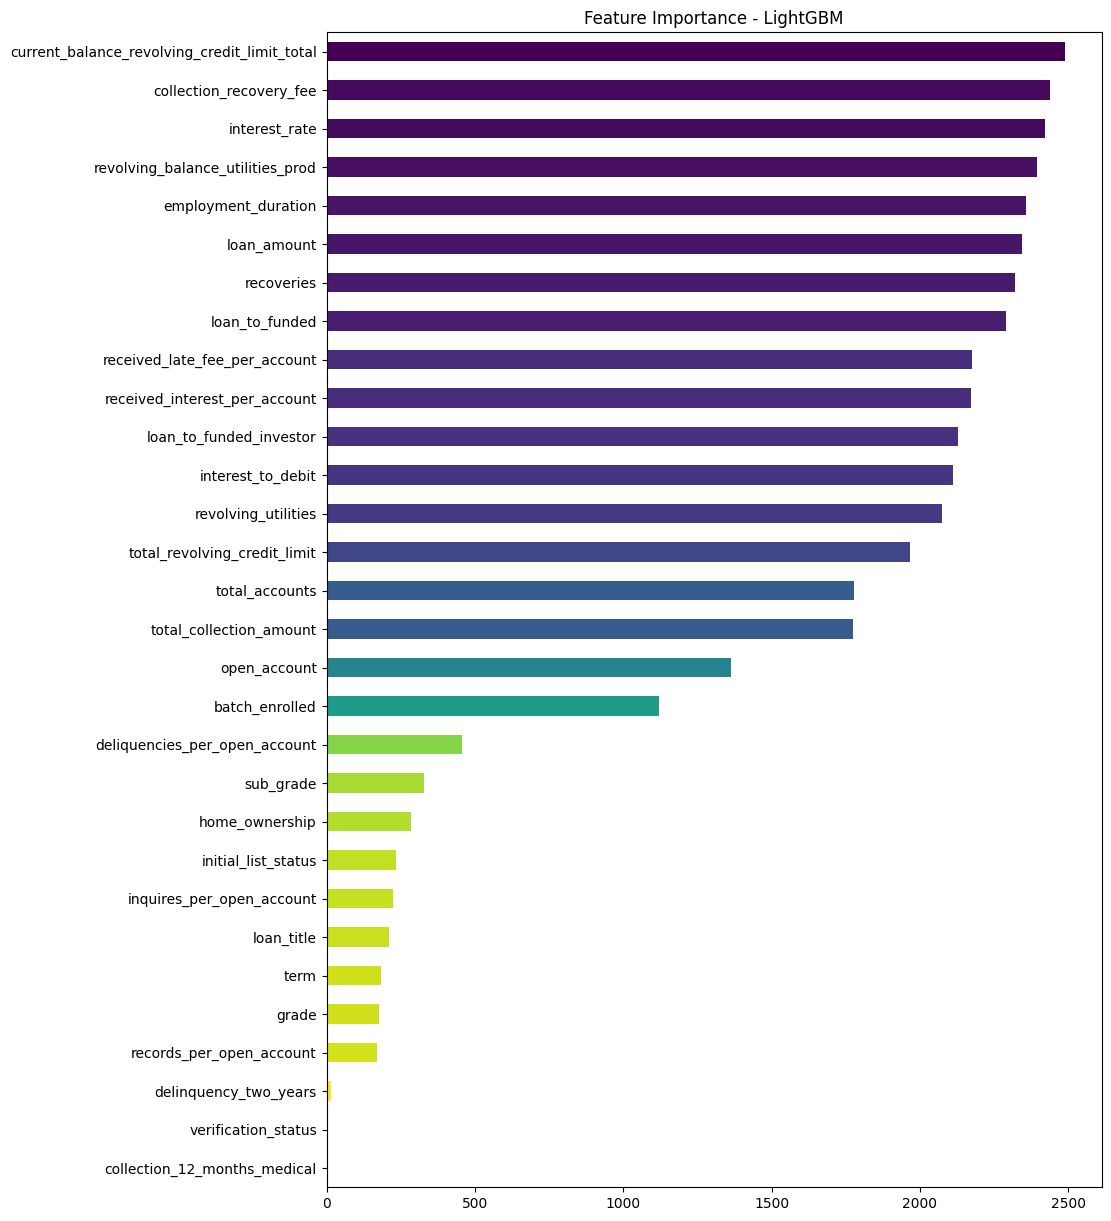

In [115]:
feature_coef = model.feature_importances_
feature_importance = pd.Series(feature_coef, index=X_train.columns)

# Create a colormap
cmap = plt.get_cmap("viridis_r")

# Normalize the importance values to be between 0 and 1 for color mapping
norm = plt.Normalize(feature_importance.abs().min(), feature_importance.abs().max())

# Create a color array based on the normalized importance
colors = [cmap(norm(value)) for value in feature_importance.abs().sort_values()]

# plot feature importances from highest to lowest
feature_importance.abs().sort_values().plot(kind='barh', figsize=(10, 15), color=colors)
plt.title('Feature Importance - LightGBM')
plt.show()

With the `LightGBMClassifier`, we saw more custom features at the top of the feature importance chart, like `current_balance_revolving_credit_limit_total`, `revolving_balance_utilities_prod`, `loan_to_funded`, `received_late_fee_per_account`, `received_interest_per_account`

In [116]:
# save the model
with open('lgbm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 7.3.3. XGBoost Classifier

Let's try a different classifier - the XGBoost Classifier.

In [117]:
def objective(trial):
    # set up the parameters for the XGB classifier
    param = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014]),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 4.0, 10.0),
        'gamma': trial.suggest_categorical('gamma', [0.1, 0.3, 0.5, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0.1, 0.5, 1.0, 3.0, 5.0]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [3.0, 5.0, 8.0, 10.0]),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'auc',
    }
    model = XGBClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    # log_losses = []
    roc_auc = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train,
                 eval_set=[(X_fold_val, y_fold_val)],
                 verbose=0)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # calculate roc-auc for this fold
        fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_auc.append(fold_auc)

    # return mean roc auc across all folds
    avg_roc_auc = np.mean(roc_auc)
    # return avg_log_loss
    return avg_roc_auc

Now we create a study to optimize our loss function. This will take a while to run.

In [118]:
# create a study
study = optuna.create_study(
    study_name='xgb_study',   # name for our study
    direction="maximize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 20
try:
    study.optimize(objective, n_trials=20)
except:
    raise

[I 2024-11-16 20:53:49,636] A new study created in memory with name: xgb_study
[I 2024-11-16 20:53:58,656] Trial 0 finished with value: 0.538692308862603 and parameters: {'learning_rate': 0.008, 'n_estimators': 547, 'max_depth': 3, 'min_child_weight': 6.668055487123519, 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.8124116243320321, 'reg_alpha': 3.0, 'reg_lambda': 8.0, 'max_delta_step': 1}. Best is trial 0 with value: 0.538692308862603.
[I 2024-11-16 20:54:14,937] Trial 1 finished with value: 0.5348634976368756 and parameters: {'learning_rate': 0.008, 'n_estimators': 526, 'max_depth': 7, 'min_child_weight': 4.804554436230851, 'gamma': 0.3, 'subsample': 0.6, 'colsample_bytree': 0.6750051887126847, 'reg_alpha': 3.0, 'reg_lambda': 8.0, 'max_delta_step': 2}. Best is trial 0 with value: 0.538692308862603.
[I 2024-11-16 20:54:28,813] Trial 2 finished with value: 0.5385688810942837 and parameters: {'learning_rate': 0.012, 'n_estimators': 803, 'max_depth': 3, 'min_child_weight': 7.8671

In [119]:
# examine the best parameters found during the trials
study.best_params

{'learning_rate': 0.008,
 'n_estimators': 547,
 'max_depth': 3,
 'min_child_weight': 6.668055487123519,
 'gamma': 1.0,
 'subsample': 0.5,
 'colsample_bytree': 0.8124116243320321,
 'reg_alpha': 3.0,
 'reg_lambda': 8.0,
 'max_delta_step': 1}

In [120]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.538692308862603

In [121]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_delta_step,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.538692,2024-11-16 20:53:49.638351,2024-11-16 20:53:58.655959,0 days 00:00:09.017608,0.812412,1.0,0.008,1,3,6.668055,547,3.0,8.0,0.5,COMPLETE
1,1,0.534863,2024-11-16 20:53:58.657640,2024-11-16 20:54:14.937405,0 days 00:00:16.279765,0.675005,0.3,0.008,2,7,4.804554,526,3.0,8.0,0.6,COMPLETE
2,2,0.538569,2024-11-16 20:54:14.938510,2024-11-16 20:54:28.813288,0 days 00:00:13.874778,0.639978,0.1,0.012,8,3,7.867111,803,0.5,5.0,0.6,COMPLETE
3,3,0.530280,2024-11-16 20:54:28.814480,2024-11-16 20:54:46.373336,0 days 00:00:17.558856,0.788286,0.3,0.009,9,9,9.246345,579,0.1,8.0,0.6,COMPLETE
4,4,0.532162,2024-11-16 20:54:46.374689,2024-11-16 20:55:00.694167,0 days 00:00:14.319478,0.677222,1.0,0.012,5,7,5.515019,632,1.0,3.0,0.5,COMPLETE


In [122]:
# save the best params to a json file
with open('xgb_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

Let's see how the model with the best parameter performs on the train and test set.

In [123]:
# retrieve the best parameters from the study
with open('xgb_params.json', 'r') as file:
    best_xgb_params = json.load(file)

best_xgb_params

{'learning_rate': 0.008,
 'n_estimators': 547,
 'max_depth': 3,
 'min_child_weight': 6.668055487123519,
 'gamma': 1.0,
 'subsample': 0.5,
 'colsample_bytree': 0.8124116243320321,
 'reg_alpha': 3.0,
 'reg_lambda': 8.0,
 'max_delta_step': 1}

In [124]:
# create a model with the parameters and fit it
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='auc', 
                      **best_xgb_params)

# Stratified K-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
roc_auc = []
log_losses = []
i = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities for log loss calculation
    y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

    # calculate roc-auc for this fold
    fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
    roc_auc.append(fold_auc)

    # calculate log-loss for this fold
    fold_logloss = log_loss(y_fold_val, y_pred_proba)
    log_losses.append(fold_logloss)

    print(f'Fold {i}: roc_auc={fold_auc:.4f}, log_loss={fold_logloss:.4f}')
    i+=1

# return mean roc auc across all folds
avg_roc_auc = np.mean(roc_auc)
# return mean logloss across all folds
avg_logloss = np.mean(log_losses)

Fold 1: roc_auc=0.5362, log_loss=0.3087
Fold 2: roc_auc=0.5516, log_loss=0.3082
Fold 3: roc_auc=0.5390, log_loss=0.3085
Fold 4: roc_auc=0.5375, log_loss=0.3086
Fold 5: roc_auc=0.5393, log_loss=0.3086


Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [125]:
# let's get the predictions
# train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Validation Log-loss: {avg_logloss:.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Validation roc-auc: {avg_roc_auc:.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Validation Log-loss: 0.3085
Test Log-loss: 0.2971
Validation roc-auc: 0.5407
Test roc-auc: 0.5649


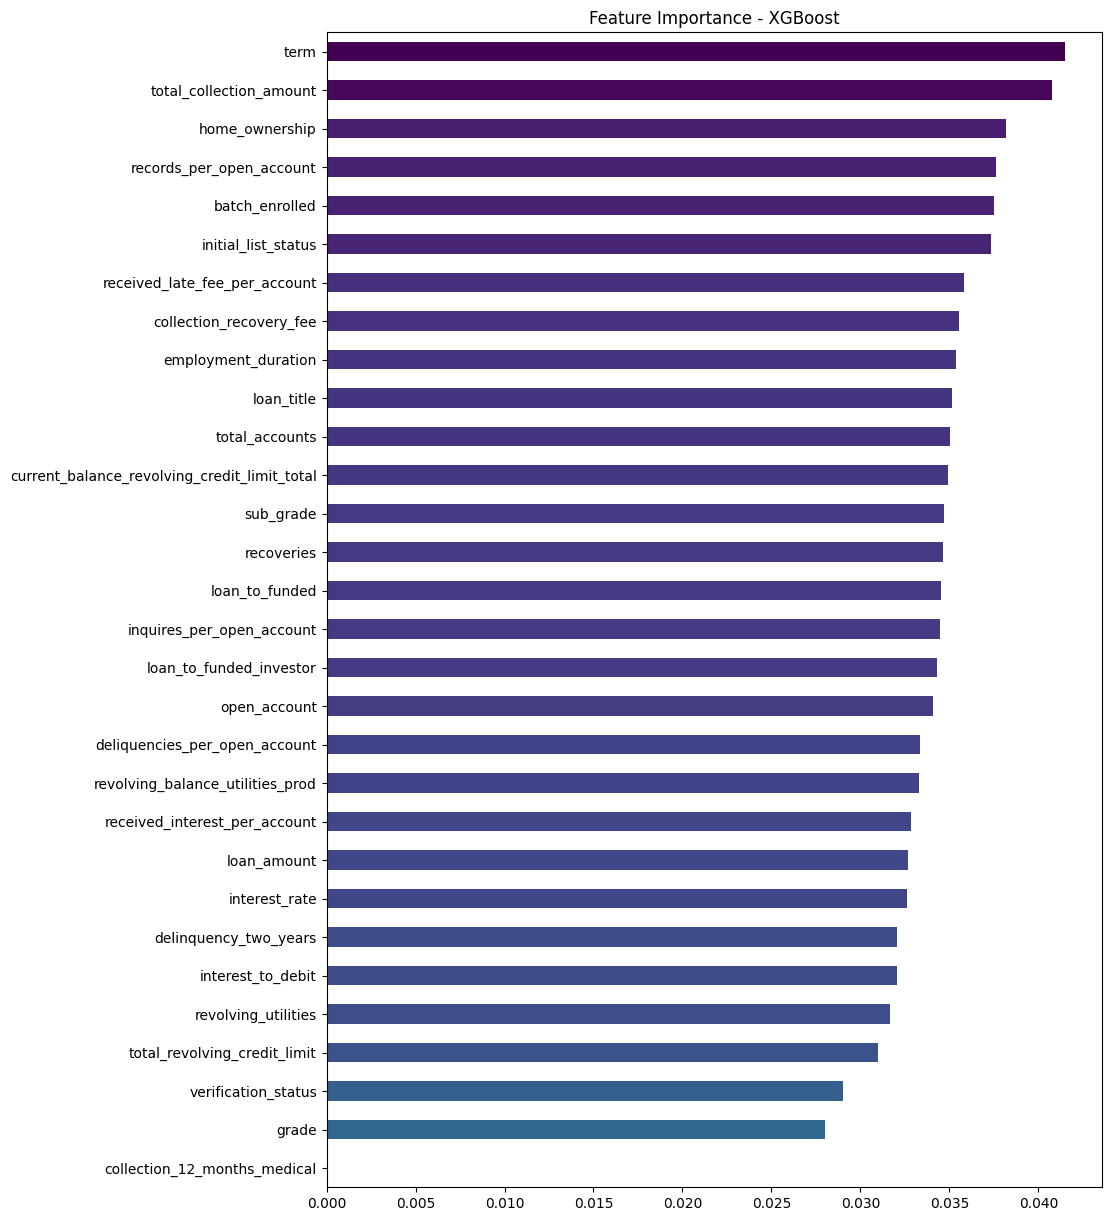

In [126]:
feature_coef = model.feature_importances_
feature_importance = pd.Series(feature_coef, index=X_train.columns)

# Create a colormap
cmap = plt.get_cmap("viridis_r")

# Normalize the importance values to be between 0 and 1 for color mapping
norm = plt.Normalize(feature_importance.abs().min(), feature_importance.abs().max())

# Create a color array based on the normalized importance
colors = [cmap(norm(value)) for value in feature_importance.abs().sort_values()]

# plot feature importances from highest to lowest
feature_importance.abs().sort_values().plot(kind='barh', figsize=(10, 15), color=colors)
plt.title('Feature Importance - XGBoost')
plt.show()

In [127]:
# save the model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 7.3.4. CatBoost Classifier

Let's try the CatBoost classifier this time

In [196]:
def objective(trial):
    # set up the parameters for the CatBoost classifier
    param = {
        'iterations': 10000,
        'early_stopping_rounds': 100,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.012, 0.014, 0.016]),
        'depth': trial.suggest_int('depth', 4, 10),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.05, 0.1, 0.3, 0.5]),
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [0.1, 0.5, 1.0, 3.0, 5.0, 10.0]),
        'random_strength': trial.suggest_float('random_strength', 4.0, 8.0),
        'bagging_temperature': trial.suggest_categorical('bagging_temperature', [0.1, 0.3, 0.5, 1.0, 3.0, 5.0, 10.0]),
        'subsample': trial.suggest_categorical('subsample', [0.1, 0.25, 0.5, 0.75, 1.0]),
        'random_state': 42,
        'logging_level': 'Silent',
        'eval_metric': 'AUC',
    }
    model = CatBoostClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    # log_losses = []
    roc_auc = []
    

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train,
                 eval_set=[(X_fold_val, y_fold_val)])
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # calculate roc-auc for this fold
        fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_auc.append(fold_auc)

    # return mean roc auc across all folds
    avg_roc_auc = np.mean(roc_auc)
    # return avg_log_loss
    return avg_roc_auc

Now we create a study to optimize our loss function. This will take a while to run.

In [197]:
# create a study
study = optuna.create_study(
    study_name='catboost_study',   # name for our study
    direction="maximize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 30
try:
    study.optimize(objective, n_trials=20)
except:
    raise

[I 2024-11-16 21:38:01,191] A new study created in memory with name: catboost_study
[I 2024-11-16 21:38:15,020] Trial 0 finished with value: 0.5389664819316635 and parameters: {'learning_rate': 0.01, 'depth': 9, 'colsample_bylevel': 0.3, 'l2_leaf_reg': 5.0, 'random_strength': 4.239261806470479, 'bagging_temperature': 5.0, 'subsample': 1.0}. Best is trial 0 with value: 0.5389664819316635.
[I 2024-11-16 21:38:49,750] Trial 1 finished with value: 0.5296989692085585 and parameters: {'learning_rate': 0.016, 'depth': 10, 'colsample_bylevel': 0.75, 'l2_leaf_reg': 5.0, 'random_strength': 5.443772089726226, 'bagging_temperature': 1.0, 'subsample': 1.0}. Best is trial 0 with value: 0.5389664819316635.
[I 2024-11-16 21:38:54,832] Trial 2 finished with value: 0.5404048925557261 and parameters: {'learning_rate': 0.014, 'depth': 4, 'colsample_bylevel': 0.1, 'l2_leaf_reg': 5.0, 'random_strength': 5.886804138622267, 'bagging_temperature': 0.5, 'subsample': 0.5}. Best is trial 2 with value: 0.540404892

In [198]:
# examine the best parameters found during the trials
study.best_params

{'learning_rate': 0.012,
 'depth': 4,
 'colsample_bylevel': 0.3,
 'l2_leaf_reg': 10.0,
 'random_strength': 4.7342996828469905,
 'bagging_temperature': 5.0,
 'subsample': 1.0}

In [199]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.5423958258628152

In [200]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_colsample_bylevel,params_depth,params_l2_leaf_reg,params_learning_rate,params_random_strength,params_subsample,state
0,0,0.538966,2024-11-16 21:38:01.193493,2024-11-16 21:38:15.020302,0 days 00:00:13.826809,5.0,0.30,9,5.0,0.010,4.239262,1.0,COMPLETE
1,1,0.529699,2024-11-16 21:38:15.021455,2024-11-16 21:38:49.750638,0 days 00:00:34.729183,1.0,0.75,10,5.0,0.016,5.443772,1.0,COMPLETE
2,2,0.540405,2024-11-16 21:38:49.751663,2024-11-16 21:38:54.832682,0 days 00:00:05.081019,0.5,0.10,4,5.0,0.014,5.886804,0.5,COMPLETE
3,3,0.536881,2024-11-16 21:38:54.833526,2024-11-16 21:39:00.833378,0 days 00:00:05.999852,0.3,0.05,8,1.0,0.012,5.092713,0.5,COMPLETE
4,4,0.539356,2024-11-16 21:39:00.834238,2024-11-16 21:39:06.265815,0 days 00:00:05.431577,5.0,0.05,6,1.0,0.012,5.822198,1.0,COMPLETE


In [201]:
# save the best params to a json file
with open('catboost_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

Let's see how the model with the best parameter performs on the train and test set.

In [202]:
# retrieve the best parameters from the study
with open('catboost_params.json', 'r') as file:
    best_cb_params = json.load(file)

best_cb_params

{'learning_rate': 0.012,
 'depth': 4,
 'colsample_bylevel': 0.3,
 'l2_leaf_reg': 10.0,
 'random_strength': 4.7342996828469905,
 'bagging_temperature': 5.0,
 'subsample': 1.0}

In [203]:
# create a model with the parameters and fit it
model = CatBoostClassifier(iterations=1000,
                           early_stopping_rounds=50,
                           eval_metric='AUC',
                           logging_level='Silent',
                           **best_cb_params)

# Stratified K-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
roc_auc = []
log_losses = []
i = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities for log loss calculation
    y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

    # calculate roc-auc for this fold
    fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
    roc_auc.append(fold_auc)

    # calculate log-loss for this fold
    fold_logloss = log_loss(y_fold_val, y_pred_proba)
    log_losses.append(fold_logloss)

    print(f'Fold {i}: roc_auc={fold_auc:.4f}, log_loss={fold_logloss:.4f}')
    i+=1

# return mean roc auc across all folds
avg_roc_auc = np.mean(roc_auc)
# return mean logloss across all folds
avg_logloss = np.mean(log_losses)

Fold 1: roc_auc=0.5351, log_loss=0.3087
Fold 2: roc_auc=0.5556, log_loss=0.3081
Fold 3: roc_auc=0.5362, log_loss=0.3087
Fold 4: roc_auc=0.5394, log_loss=0.3085
Fold 5: roc_auc=0.5371, log_loss=0.3086


Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [204]:
# let's get the predictions
# train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Validation Log-loss: {avg_logloss:.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Validation roc-auc: {avg_roc_auc:.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Validation Log-loss: 0.3085
Test Log-loss: 0.2971
Validation roc-auc: 0.5407
Test roc-auc: 0.5620


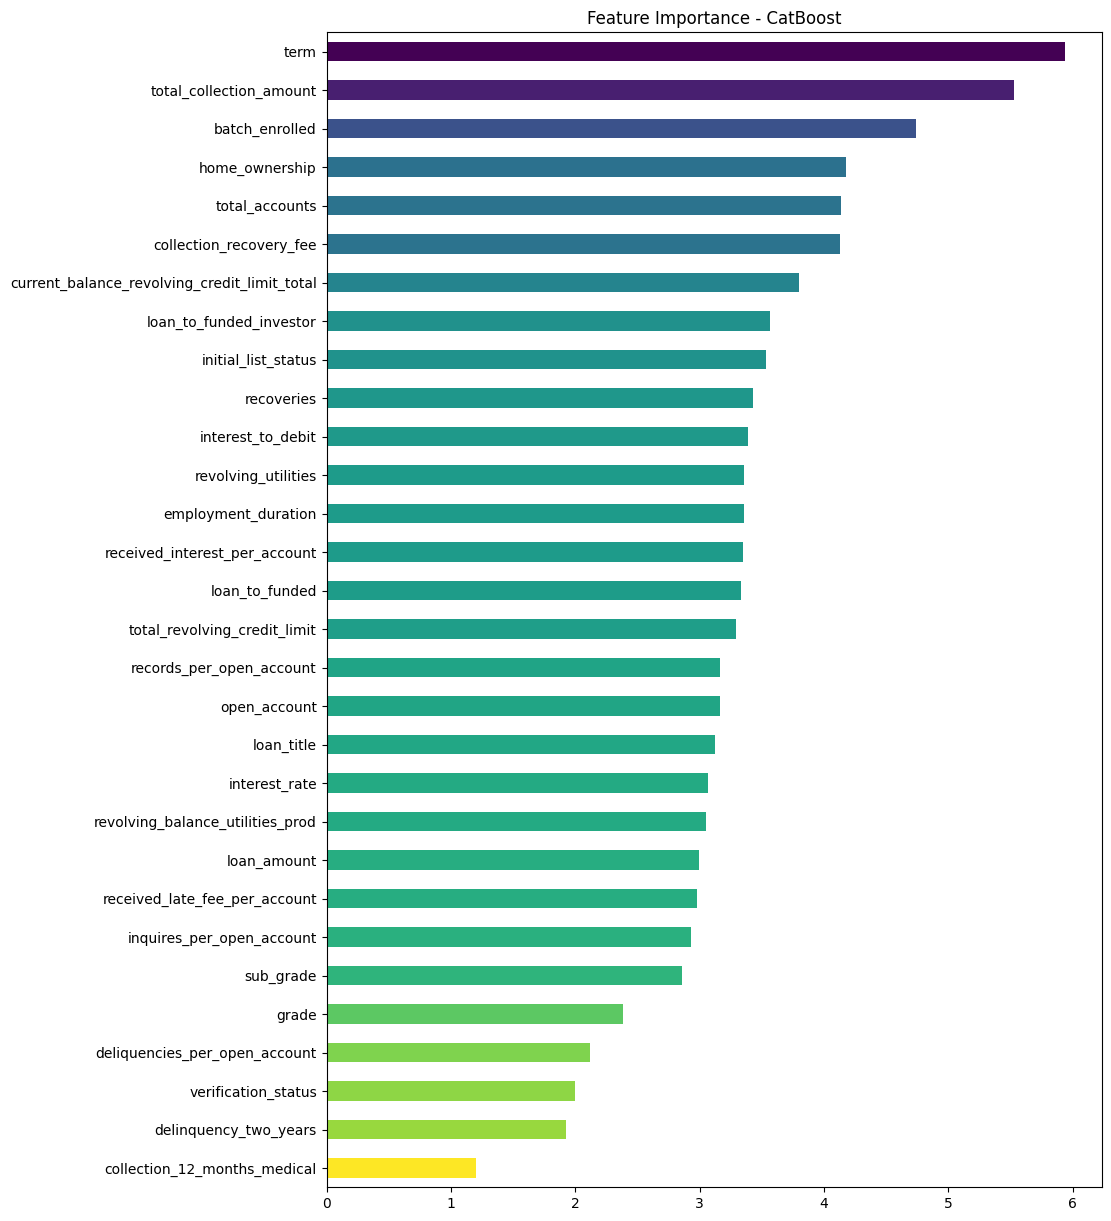

In [205]:
feature_coef = model.feature_importances_
feature_importance = pd.Series(feature_coef, index=X_train.columns)

# Create a colormap
cmap = plt.get_cmap("viridis_r")

# Normalize the importance values to be between 0 and 1 for color mapping
norm = plt.Normalize(feature_importance.abs().min(), feature_importance.abs().max())

# Create a color array based on the normalized importance
colors = [cmap(norm(value)) for value in feature_importance.abs().sort_values()]

# plot feature importances from highest to lowest
feature_importance.abs().sort_values().plot(kind='barh', figsize=(10, 15), color=colors)
plt.title('Feature Importance - CatBoost')
plt.show()

In [206]:
# save the model
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Looks like all of the models we've tried perform decently well as all of them either perform the same as or outperform the benchmark model. However, whether the improvement is statistically significant enough to justify using a more complicated model remains to be tested. On top of that, to test if these models are overfitting, we need to test their performance on the true test set provided by the competition as well. Unfortunately, the test set from this hackathon does not include the labels for the data, so we can't test it for this analysis.